## Preparing visualization for operational recommendations

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import requests
import seaborn as sns
import pandas as pd
import scipy
import os
from glob import glob

In [1]:
cleaned_df = pd.read_excel('ttc-streetcar-delay-data-2024_cleaned.xlsx', index_col=None,
                           header=0)
cleaned_df.head()

NameError: name 'pd' is not defined

Line 501 is the most delay occurred line. I want to explore routinly delayed vehicle numbers.

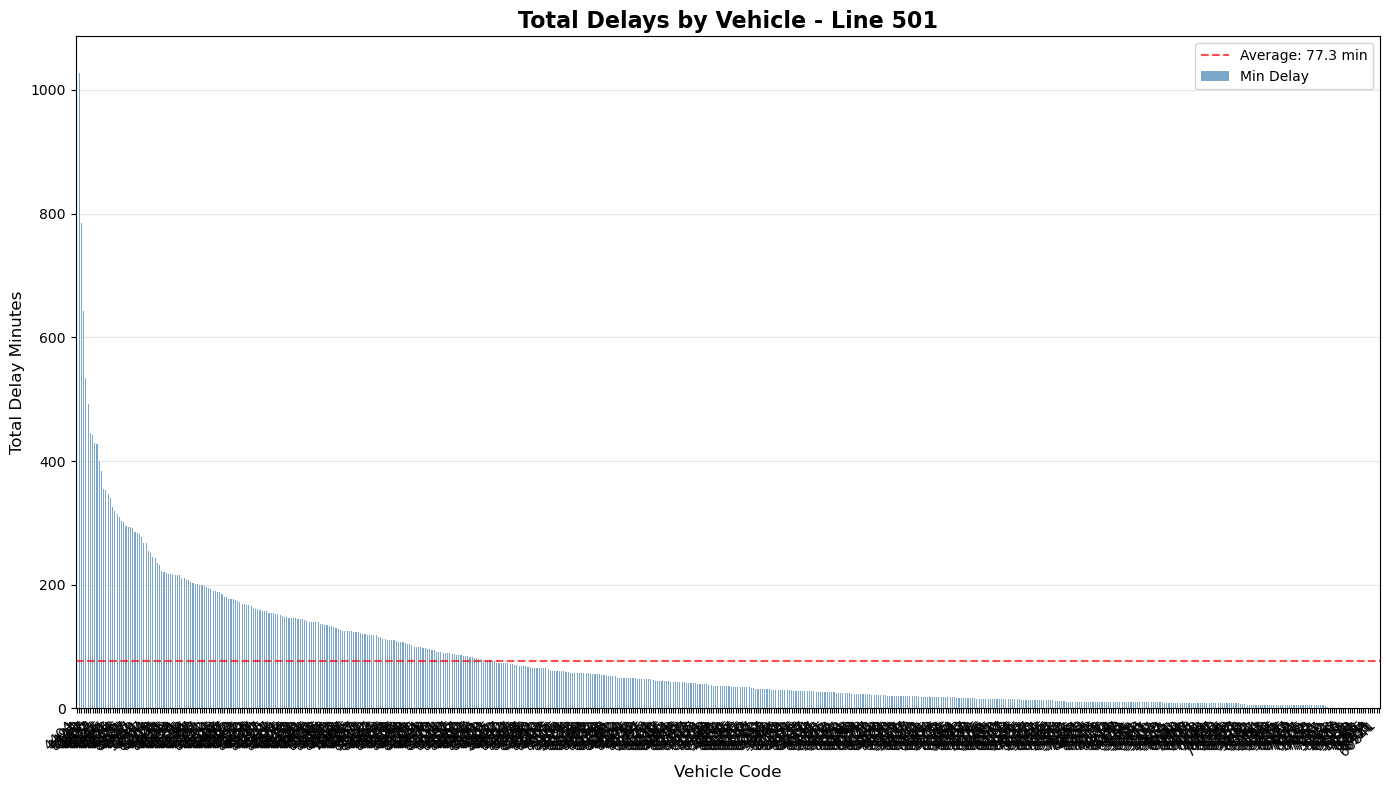

In [ ]:
line_501_df = cleaned_df[cleaned_df['Line'] == 501]

vehicle_delays = line_501_df.groupby('Vehicle')['Min Delay'].sum().sort_values(ascending=False)

# Create the plot
plt.figure(figsize=(14, 8))  

# Create bar plot
vehicle_delays.plot(kind='bar', color='steelblue', alpha=0.7)
    
plt.title('Total Delays by Vehicle - Line 501', fontsize=16, fontweight='bold')
plt.xlabel('Vehicle Code', fontsize=12)
plt.ylabel('Total Delay Minutes', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
    
# Add some statistics to the plot
max_delay = vehicle_delays.max()
avg_delay = vehicle_delays.mean()
plt.axhline(y=avg_delay, color='red', linestyle='--', alpha=0.7, 
            label=f'Average: {avg_delay:.1f} min')
    
plt.legend()
plt.tight_layout()
plt.show()

Exporing deylaed vehicles ony for 501 line is not ideal so expand the filter and used all lines to see how vehicles delays vary

In [ ]:
# Create table with lines and number of unique vehicle codes
vehicle_count_by_line = cleaned_df.groupby('Line')['Vehicle'].nunique().sort_values(ascending=False)

# Convert to DataFrame for better display
vehicle_count_table = vehicle_count_by_line.reset_index()
vehicle_count_table.columns = ['Line', 'Number of Unique Vehicles']

# Display the table
print("Number of Unique Vehicles by Line:")
print(vehicle_count_table)


Number of Unique Vehicles by Line:
    Line  Number of Unique Vehicles
0    510                        622
1    501                        585
2    512                        566
3    504                        312
4    509                        263
5    506                        249
6    505                        236
7    511                        230
8    503                        203
9    507                        163
10   301                        132
11   306                         72
12   508                         70
13   304                         32
14   310                         22
15   305                         14
16   303                         11
17   312                          4


I want to visulaize top 10 delayed vehicles

In [ ]:
# Identify top 10 vehicles with most total delays across all lines
top_10_vehicles = cleaned_df.groupby('Vehicle')['Min Delay'].sum().nlargest(10)
print("Top 10 Vehicles with Most Total Delays:")
print(top_10_vehicles)
print("\n" + "="*50)

# Filter dataset for these top 10 vehicles
top_vehicles_df = cleaned_df[cleaned_df['Vehicle'].isin(top_10_vehicles.index)]

print(f"Total records for top 10 delayed vehicles: {len(top_vehicles_df)}")
print(f"Unique vehicles in filtered data: {top_vehicles_df['Vehicle'].nunique()}")

Top 10 Vehicles with Most Total Delays:
Vehicle
4491    2702
4404    2005
4444    1839
4597    1807
4426    1709
4507    1599
4494    1510
4563    1472
4414    1471
4451    1456
Name: Min Delay, dtype: int64

Total records for top 10 delayed vehicles: 575
Unique vehicles in filtered data: 10


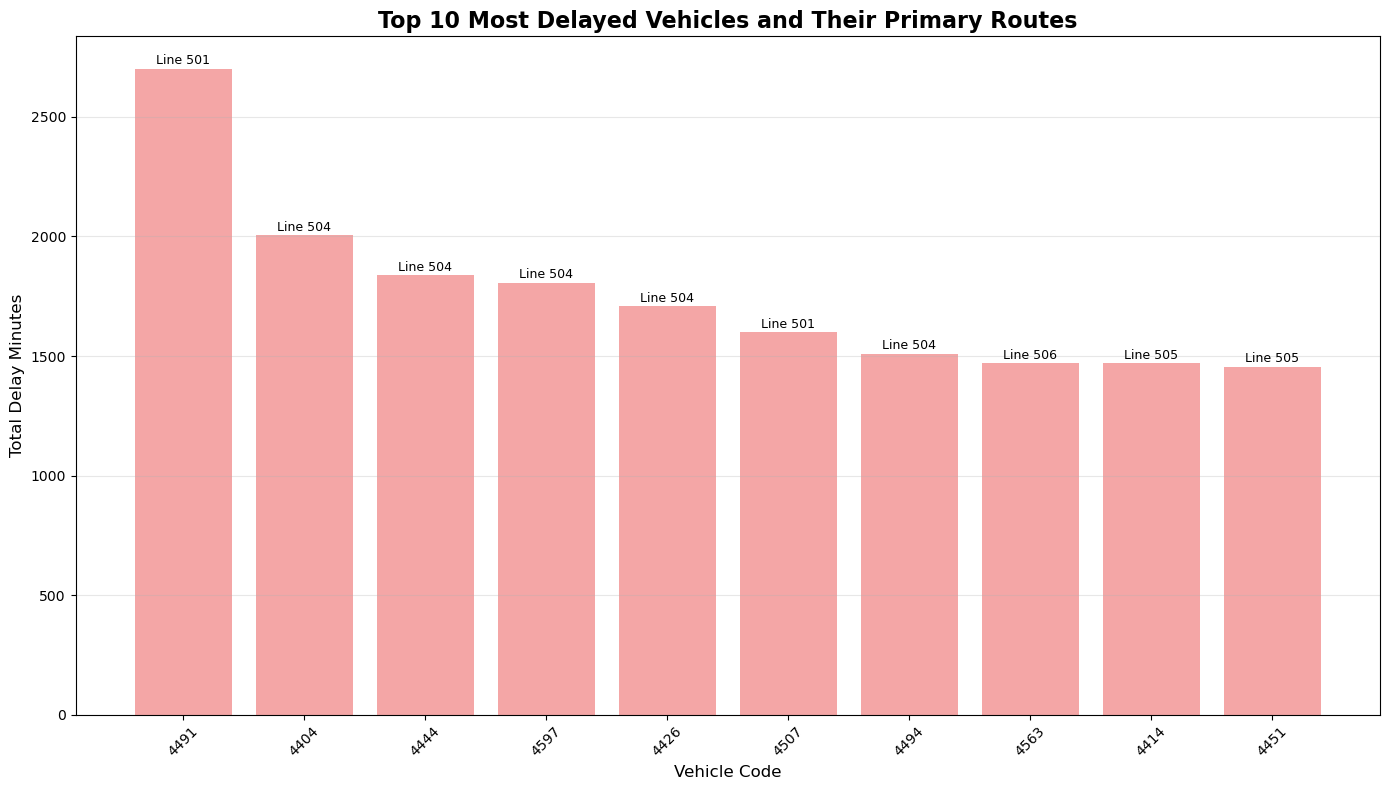

In [ ]:
# Plot total delays by vehicle with their most common routes
plt.figure(figsize=(14, 8))

# Get the most common line for each top vehicle
vehicle_main_routes = top_vehicles_df.groupby('Vehicle').agg({
    'Min Delay': 'sum',
    'Line': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'Multiple'
}).sort_values('Min Delay', ascending=False)

# Create bar plot
bars = plt.bar(vehicle_main_routes.index.astype(str), 
               vehicle_main_routes['Min Delay'], 
               color='lightcoral', alpha=0.7)

# Add route labels on bars
for i, (vehicle, row) in enumerate(vehicle_main_routes.iterrows()):
    plt.text(i, row['Min Delay'] + 5, f"Line {row['Line']}", 
             ha='center', va='bottom', rotation=0, fontsize=9)

plt.title('Top 10 Most Delayed Vehicles and Their Primary Routes', fontsize=16, fontweight='bold')
plt.xlabel('Vehicle Code', fontsize=12)
plt.ylabel('Total Delay Minutes', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Visualizing 10 least delayed vehicles and add number of incidents 

In [ ]:
# Step 1: Identify vehicles with delays (exclude vehicles with 0 or minimal delays)
vehicle_delay_stats = cleaned_df.groupby('Vehicle').agg({
    'Min Delay': ['sum', 'count', 'mean'],
    'Line': 'nunique'
}).round(2)

# Flatten column names
vehicle_delay_stats.columns = ['Total Delay', 'Delay Incidents', 'Avg Delay per Incident', 'Number of Routes']

# Filter for vehicles with at least 5 delay incidents (to get meaningful data)
qualified_vehicles = vehicle_delay_stats[vehicle_delay_stats['Delay Incidents'] >= 5]

# Get the 10 least delayed vehicles from qualified ones
least_10_vehicles = qualified_vehicles.nsmallest(10, 'Total Delay')
print("Top 10 Least Delayed Vehicles (with at least 5 delay incidents):")
print(least_10_vehicles)
print("\n" + "="*60)

Top 10 Least Delayed Vehicles (with at least 5 delay incidents):
         Total Delay  Delay Incidents  Avg Delay per Incident  \
Vehicle                                                         
8627              15                5                    3.00   
8670              17                6                    2.83   
8806              17                5                    3.40   
8384              18                5                    3.60   
8726              19                5                    3.80   
8331              20                5                    4.00   
8620              20                5                    4.00   
8728              22                5                    4.40   
8822              22                5                    4.40   
8143              23                5                    4.60   

         Number of Routes  
Vehicle                    
8627                    2  
8670                    4  
8806                    3  
8384          

Top 10 Least Delayed Vehicles (with at least 5 delay incidents):
         Total Delay  Delay Incidents  Avg Delay per Incident  \
Vehicle                                                         
8627              15                5                    3.00   
8670              17                6                    2.83   
8806              17                5                    3.40   
8384              18                5                    3.60   
8726              19                5                    3.80   
8331              20                5                    4.00   
8620              20                5                    4.00   
8728              22                5                    4.40   
8822              22                5                    4.40   
8143              23                5                    4.60   

         Number of Routes  
Vehicle                    
8627                    2  
8670                    4  
8806                    3  
8384          

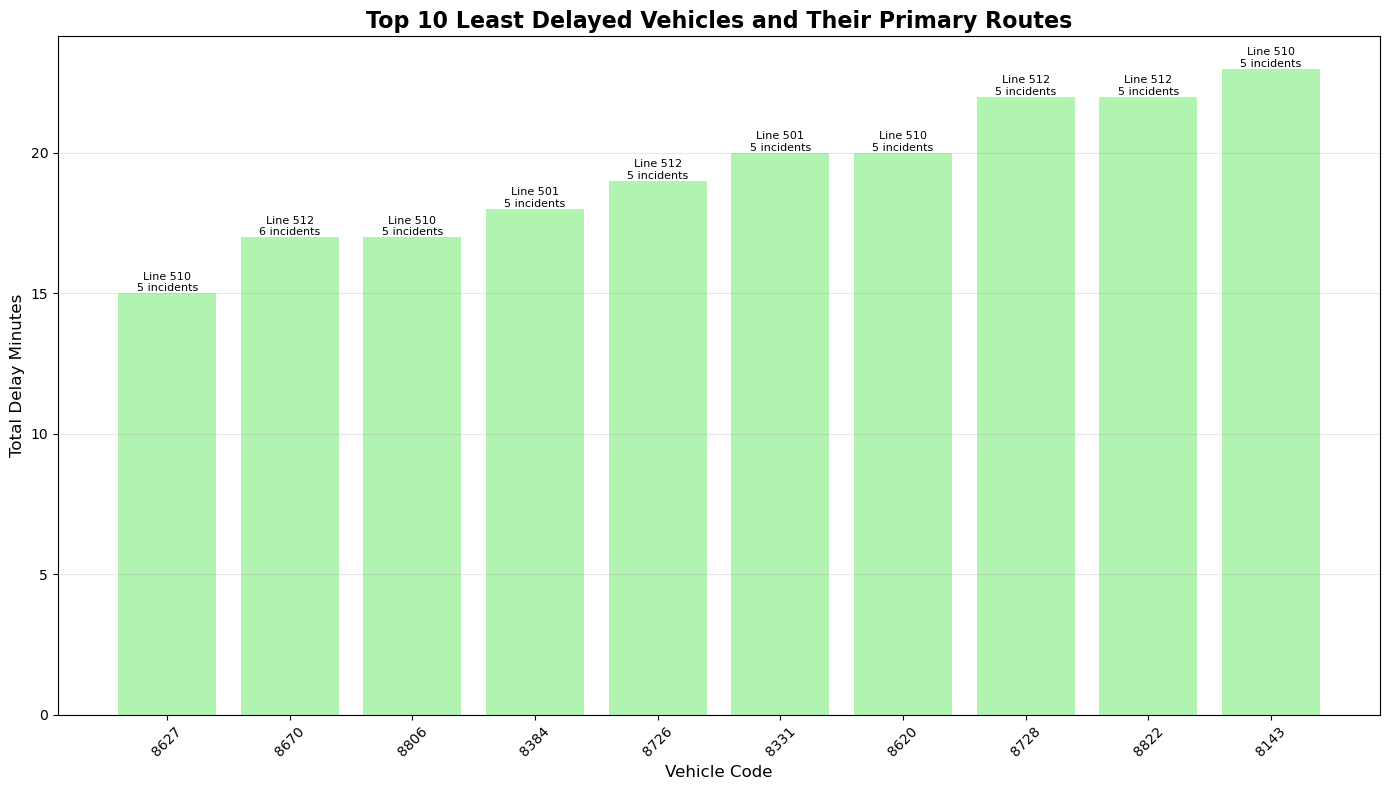

In [ ]:
# Identify vehicles with delays (exclude vehicles with 0 or minimal delays)
vehicle_delay_stats = cleaned_df.groupby('Vehicle').agg({
    'Min Delay': ['sum', 'count', 'mean'],
    'Line': 'nunique'
}).round(2)

# Flatten column names
vehicle_delay_stats.columns = ['Total Delay', 'Delay Incidents', 'Avg Delay per Incident', 'Number of Routes']

# Filter for vehicles with at least 5 delay incidents (to get meaningful data)
qualified_vehicles = vehicle_delay_stats[vehicle_delay_stats['Delay Incidents'] >= 5]

# Get the 10 least delayed vehicles from qualified ones
least_10_vehicles = qualified_vehicles.nsmallest(10, 'Total Delay')
print("Top 10 Least Delayed Vehicles (with at least 5 delay incidents):")
print(least_10_vehicles)
print("\n" + "="*60)

# FIXED Plot 1: Total delays and efficiency of least delayed vehicles
plt.figure(figsize=(14, 8))

# Get the data for least delayed vehicles
least_vehicles_df = cleaned_df[cleaned_df['Vehicle'].isin(least_10_vehicles.index)]

# Fixed aggregation - use proper column names that exist in the DataFrame
vehicle_main_routes = least_vehicles_df.groupby('Vehicle').agg({
    'Min Delay': 'sum',
    'Line': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'Multiple'
}).sort_values('Min Delay', ascending=True)

# Add the delay incidents count from our previous calculation
vehicle_main_routes['Delay Incidents'] = least_10_vehicles['Delay Incidents']

# Create bar plot
bars = plt.bar(vehicle_main_routes.index.astype(str), 
               vehicle_main_routes['Min Delay'], 
               color='lightgreen', alpha=0.7)

# Add route labels and incident count on bars
for i, (vehicle, row) in enumerate(vehicle_main_routes.iterrows()):
    plt.text(i, row['Min Delay'] , f"Line {row['Line']}\n{row['Delay Incidents']} incidents", 
             ha='center', va='bottom', rotation=0, fontsize=8)

plt.title('Top 10 Least Delayed Vehicles and Their Primary Routes', fontsize=16, fontweight='bold')
plt.xlabel('Vehicle Code', fontsize=12)
plt.ylabel('Total Delay Minutes', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

it is important to understand distribution of delay minutes and delay gaps. SO I visulaize the histogram

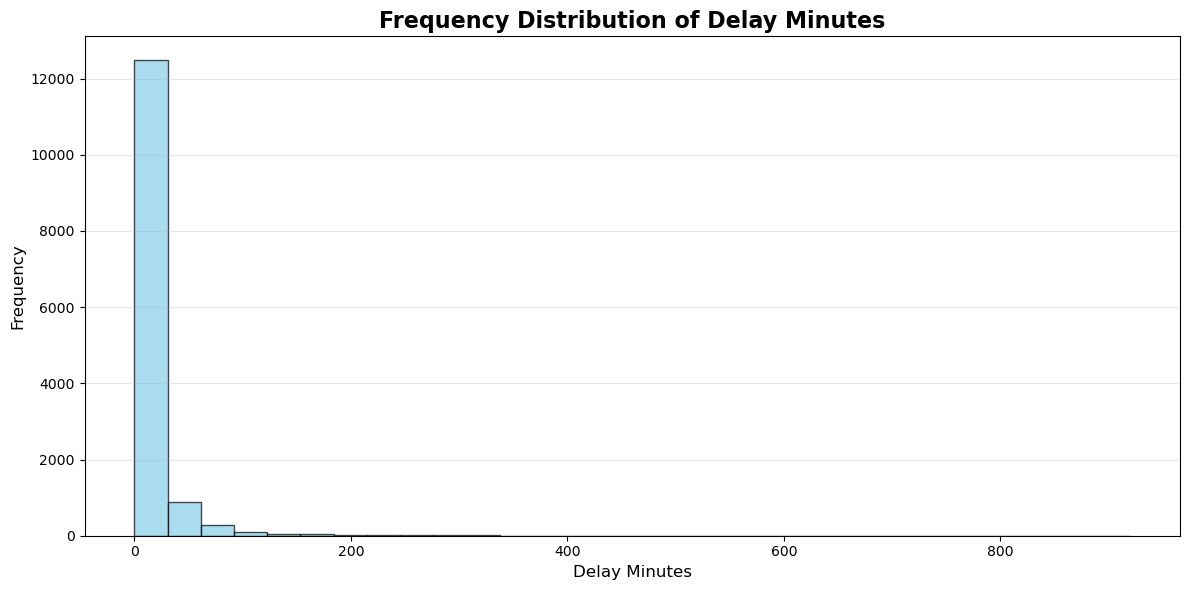

In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(cleaned_df['Min Delay'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Frequency Distribution of Delay Minutes', fontsize=16, fontweight='bold')
plt.xlabel('Delay Minutes', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

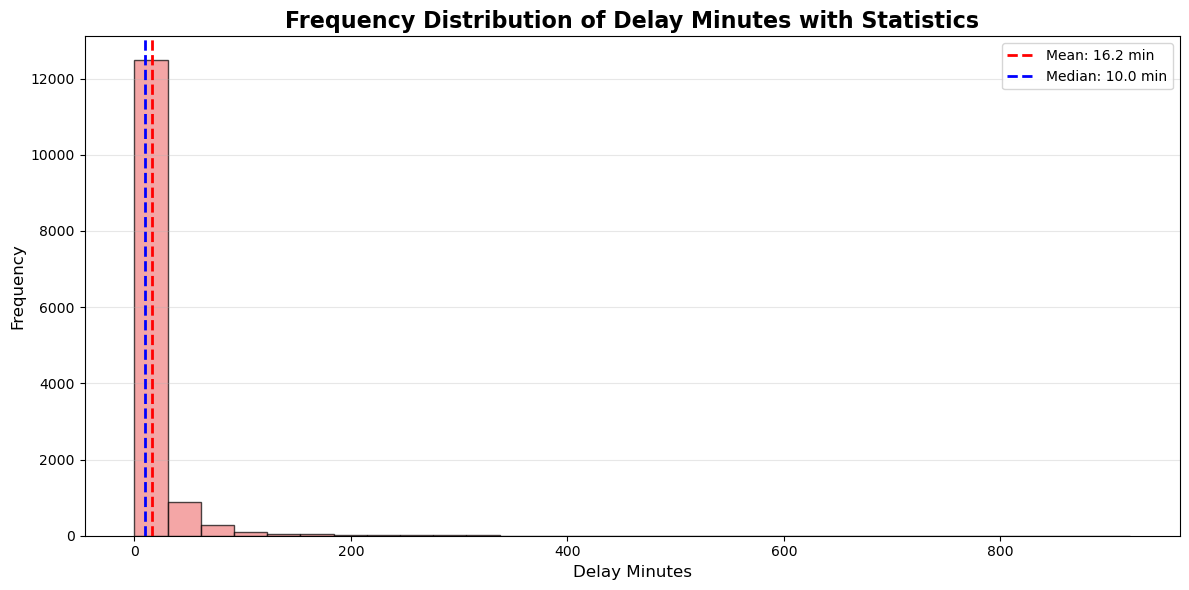

Delay Statistics:
Mean delay: 16.18 minutes
Median delay: 10.00 minutes
Standard deviation: 34.41 minutes
Minimum delay: 0 minutes
Maximum delay: 920 minutes


In [ ]:
plt.figure(figsize=(12, 6))
n, bins, patches = plt.hist(cleaned_df['Min Delay'], bins=30, color='lightcoral', edgecolor='black', alpha=0.7)

# Add statistical information
mean_delay = cleaned_df['Min Delay'].mean()
median_delay = cleaned_df['Min Delay'].median()
std_delay = cleaned_df['Min Delay'].std()

plt.axvline(mean_delay, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_delay:.1f} min')
plt.axvline(median_delay, color='blue', linestyle='--', linewidth=2, label=f'Median: {median_delay:.1f} min')

plt.title('Frequency Distribution of Delay Minutes with Statistics', fontsize=16, fontweight='bold')
plt.xlabel('Delay Minutes', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Delay Statistics:")
print(f"Mean delay: {mean_delay:.2f} minutes")
print(f"Median delay: {median_delay:.2f} minutes")
print(f"Standard deviation: {std_delay:.2f} minutes")
print(f"Minimum delay: {cleaned_df['Min Delay'].min()} minutes")
print(f"Maximum delay: {cleaned_df['Min Delay'].max()} minutes")

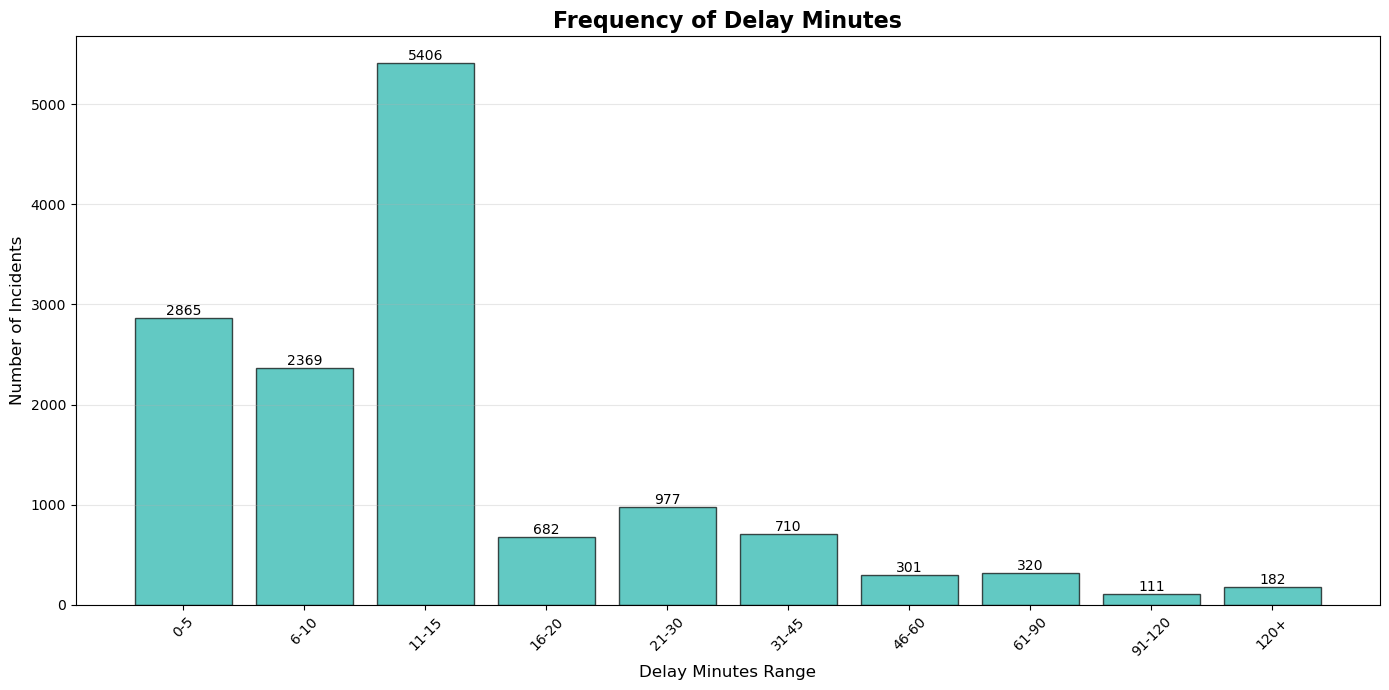

In [ ]:
# Define custom bins for delays
delay_bins = [0, 5, 10, 15, 20, 30, 45, 60, 90, 120, cleaned_df['Min Delay'].max()]
bin_labels = ['0-5', '6-10', '11-15', '16-20', '21-30', '31-45', '46-60', '61-90', '91-120', '120+']

plt.figure(figsize=(14, 7))
binned_data = pd.cut(cleaned_df['Min Delay'], bins=delay_bins, labels=bin_labels, right=False)
frequency = binned_data.value_counts().sort_index()

plt.bar(frequency.index, frequency.values, color='lightseagreen', alpha=0.7, edgecolor='black')
plt.title('Frequency of Delay Minutes', fontsize=16, fontweight='bold')
plt.xlabel('Delay Minutes Range', fontsize=12)
plt.ylabel('Number of Incidents', fontsize=12)
plt.xticks(rotation=45)

# Add value labels on bars
for i, v in enumerate(frequency.values):
    plt.text(i, v + 0.1, str(v), ha='center', va='bottom')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

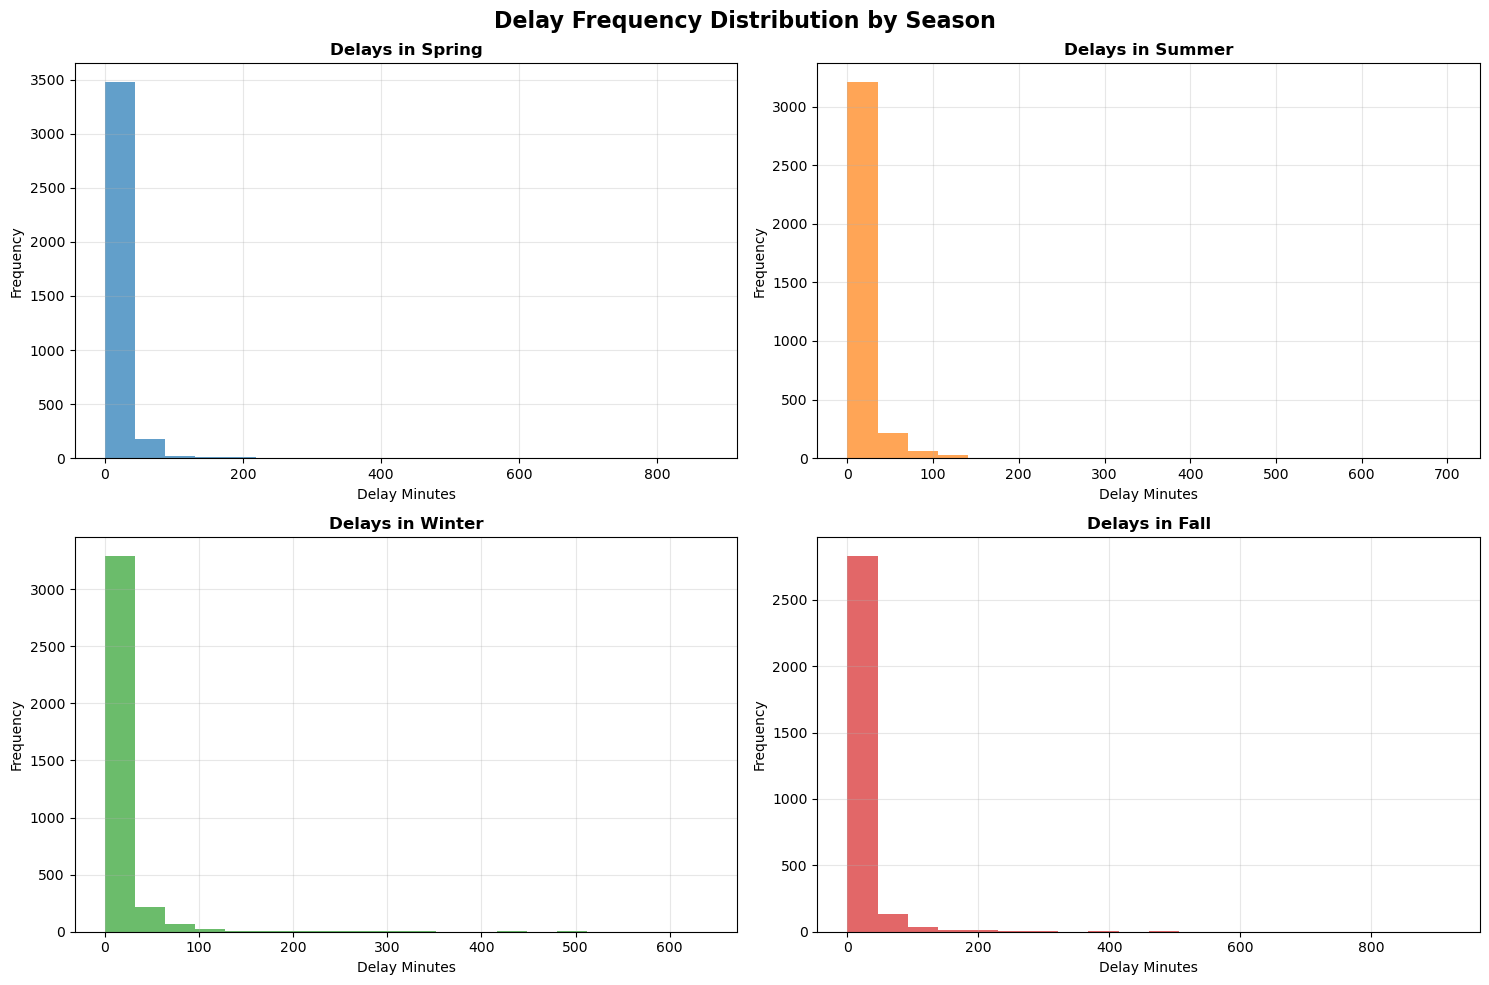

In [ ]:
# Compare delay distributions by different categories
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

# By Season
seasons = cleaned_df['Season'].unique()
for i, season in enumerate(seasons):
    if i < 4:  # Ensure we don't exceed subplot count
        season_data = cleaned_df[cleaned_df['Season'] == season]['Min Delay']
        axes[i].hist(season_data, bins=20, alpha=0.7, color=f'C{i}')
        axes[i].set_title(f'Delays in {season}', fontweight='bold')
        axes[i].set_xlabel('Delay Minutes')
        axes[i].set_ylabel('Frequency')
        axes[i].grid(alpha=0.3)

plt.suptitle('Delay Frequency Distribution by Season', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

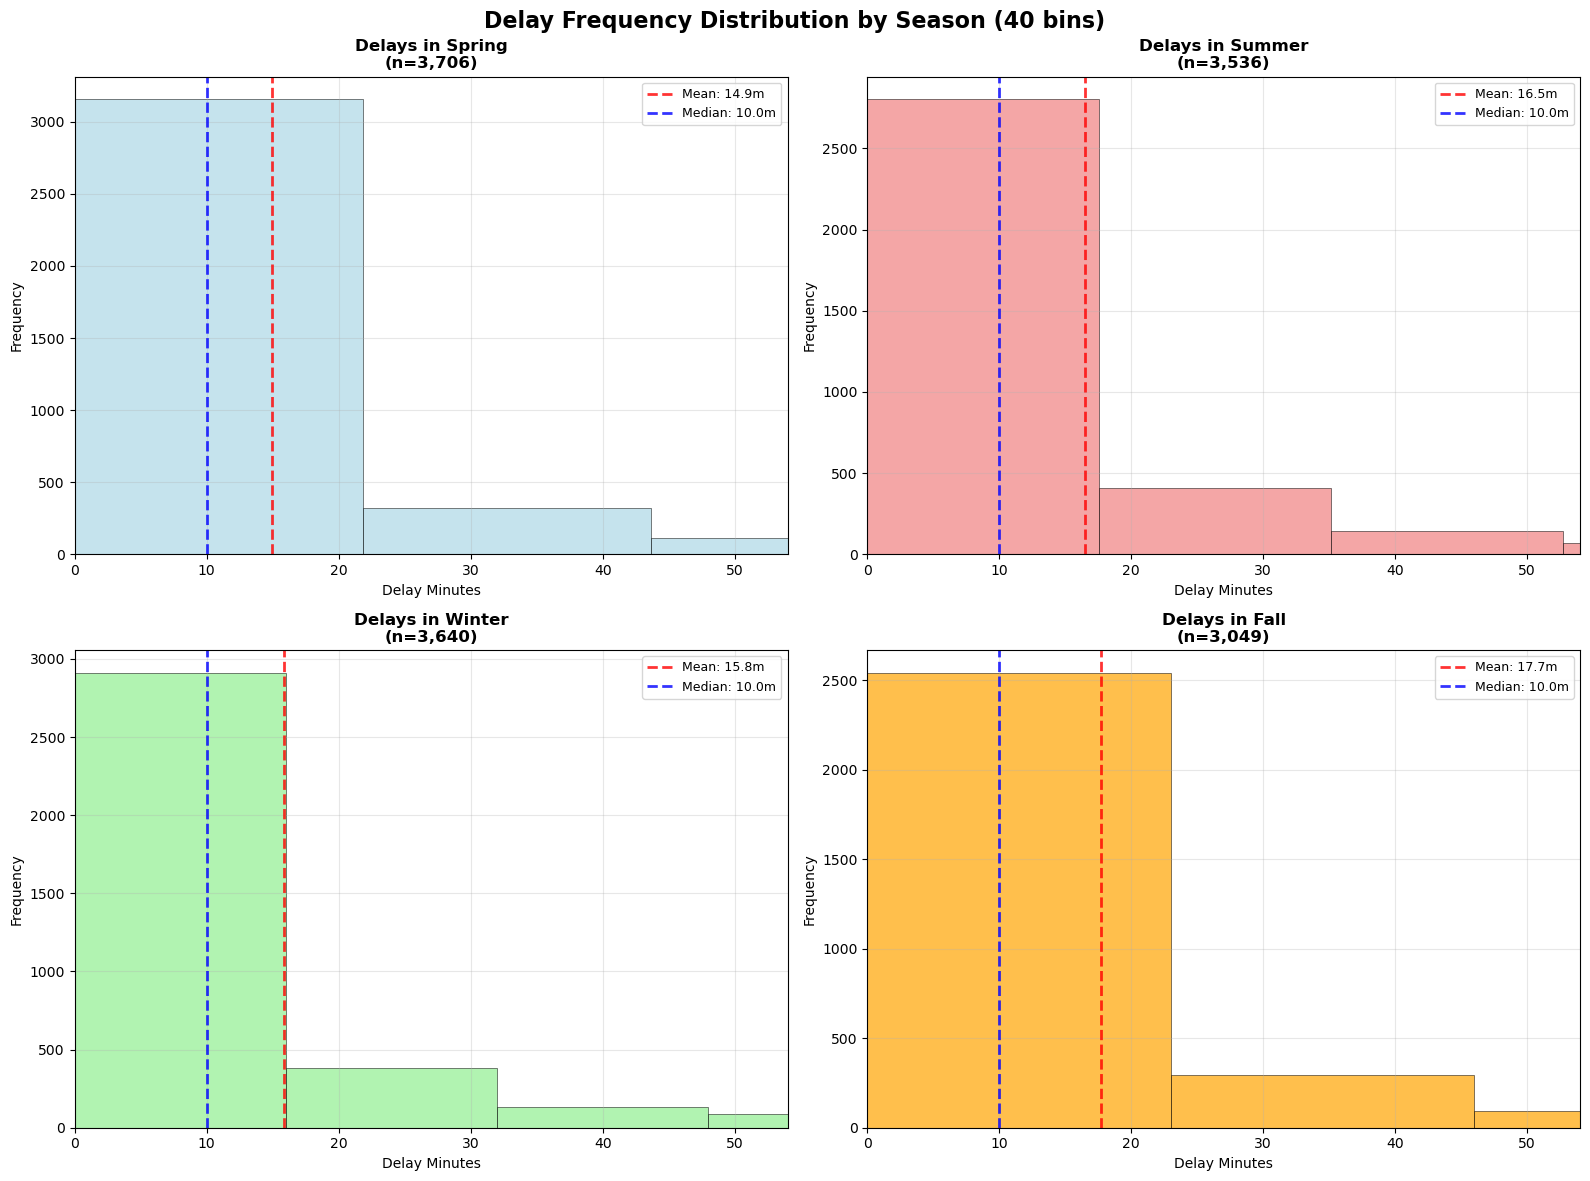

SEASONAL DELAY STATISTICS

Spring:
  Count: 3,706 incidents
  Mean: 14.93 minutes
  Median: 10.00 minutes
  Std Dev: 34.22 minutes
  Max: 873 minutes

Summer:
  Count: 3,536 incidents
  Mean: 16.48 minutes
  Median: 10.00 minutes
  Std Dev: 32.60 minutes
  Max: 703 minutes

Winter:
  Count: 3,640 incidents
  Mean: 15.84 minutes
  Median: 10.00 minutes
  Std Dev: 31.53 minutes
  Max: 640 minutes

Fall:
  Count: 3,049 incidents
  Mean: 17.74 minutes
  Median: 10.00 minutes
  Std Dev: 39.56 minutes
  Max: 920 minutes


In [ ]:
# Compare delay distributions by different categories with more bins
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

# By Season
seasons = cleaned_df['Season'].unique()
colors = ['lightblue', 'lightcoral', 'lightgreen', 'orange']

for i, season in enumerate(seasons):
    if i < 4:  # Ensure we don't exceed subplot count
        season_data = cleaned_df[cleaned_df['Season'] == season]['Min Delay']
        
        # Increased bins from 20 to 40 for more detailed distribution
        n, bins, patches = axes[i].hist(season_data, bins=40, alpha=0.7, color=colors[i], edgecolor='black', linewidth=0.5)
        
        # Add statistical information to each subplot
        mean_delay = season_data.mean()
        median_delay = season_data.median()
        
        axes[i].axvline(mean_delay, color='red', linestyle='--', linewidth=2, alpha=0.8, label=f'Mean: {mean_delay:.1f}m')
        axes[i].axvline(median_delay, color='blue', linestyle='--', linewidth=2, alpha=0.8, label=f'Median: {median_delay:.1f}m')
        
        axes[i].set_title(f'Delays in {season}\n(n={len(season_data):,})', fontweight='bold', fontsize=12)
        axes[i].set_xlabel('Delay Minutes', fontsize=10)
        axes[i].set_ylabel('Frequency', fontsize=10)
        axes[i].grid(alpha=0.3)
        axes[i].legend(fontsize=9)
        
        # Set consistent x-axis limits across all subplots for better comparison
        max_delay = cleaned_df['Min Delay'].quantile(0.95)  # Use 95th percentile to avoid extreme outliers
        axes[i].set_xlim(0, max_delay)

plt.suptitle('Delay Frequency Distribution by Season (40 bins)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print seasonal statistics
print("SEASONAL DELAY STATISTICS")
print("="*50)
for season in seasons:
    season_data = cleaned_df[cleaned_df['Season'] == season]['Min Delay']
    print(f"\n{season}:")
    print(f"  Count: {len(season_data):,} incidents")
    print(f"  Mean: {season_data.mean():.2f} minutes")
    print(f"  Median: {season_data.median():.2f} minutes")
    print(f"  Std Dev: {season_data.std():.2f} minutes")
    print(f"  Max: {season_data.max()} minutes")

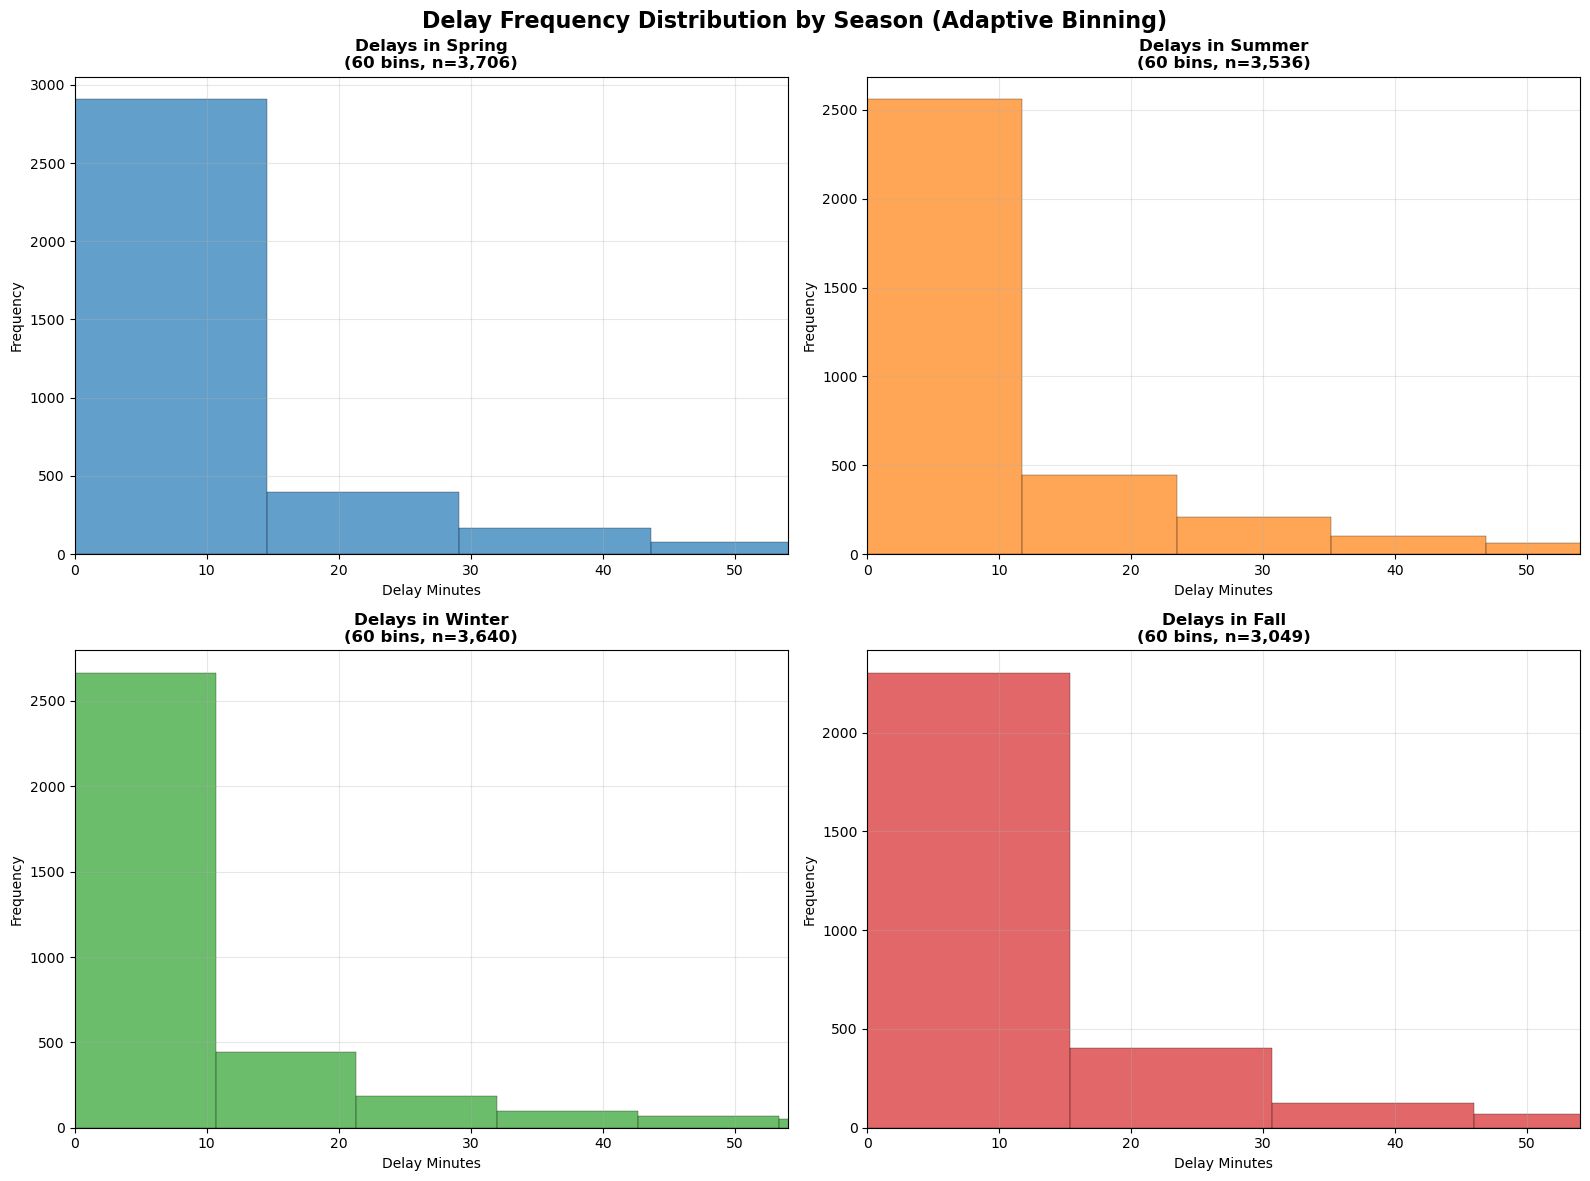

In [ ]:
# Version with adaptive bin sizing based on data characteristics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

seasons = cleaned_df['Season'].unique()

for i, season in enumerate(seasons):
    if i < 4:
        season_data = cleaned_df[cleaned_df['Season'] == season]['Min Delay']
        
        # Adaptive bin calculation based on data range and size
        data_range = season_data.max() - season_data.min()
        # Use more bins for larger datasets, fewer for smaller ones
        adaptive_bins = min(60, max(30, int(len(season_data) / 50)))
        
        n, bins, patches = axes[i].hist(season_data, bins=adaptive_bins, alpha=0.7, 
                                       color=f'C{i}', edgecolor='black', linewidth=0.3)
        
        axes[i].set_title(f'Delays in {season}\n({adaptive_bins} bins, n={len(season_data):,})', 
                         fontweight='bold', fontsize=12)
        axes[i].set_xlabel('Delay Minutes', fontsize=10)
        axes[i].set_ylabel('Frequency', fontsize=10)
        axes[i].grid(alpha=0.3)
        
        # Set consistent x-axis limits
        axes[i].set_xlim(0, cleaned_df['Min Delay'].quantile(0.95))

plt.suptitle('Delay Frequency Distribution by Season (Adaptive Binning)', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Print detailed statistics
print("DELAY MINUTES - DETAILED STATISTICS")
print("="*40)
print(cleaned_df['Min Delay'].describe())
print(f"\nSkewness: {cleaned_df['Min Delay'].skew():.2f}")
print(f"Kurtosis: {cleaned_df['Min Delay'].kurtosis():.2f}")

# Most common delay values
print(f"\nTop 10 Most Common Delay Values:")
print(cleaned_df['Min Delay'].value_counts().head(10))

DELAY MINUTES - DETAILED STATISTICS
count    13931.000000
mean        16.176082
std         34.413862
min          0.000000
25%          5.000000
50%         10.000000
75%         13.000000
max        920.000000
Name: Min Delay, dtype: float64

Skewness: 10.87
Kurtosis: 183.49

Top 10 Most Common Delay Values:
Min Delay
10    4815
0     2239
8      733
5      667
9      399
20     340
6      326
3      295
4      290
15     282
Name: count, dtype: int64


Histogram of Minute Gap

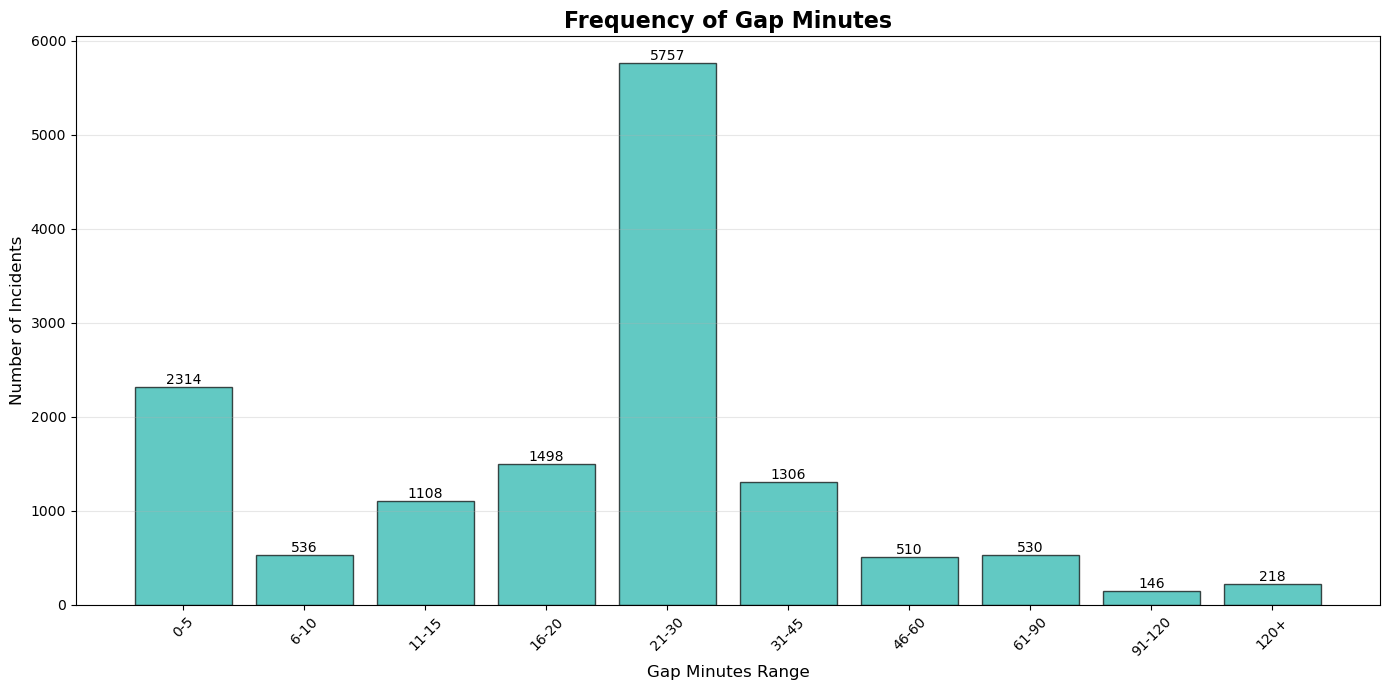

MIN GAP STATISTICS
count    13924.000000
mean        24.114694
std         36.002825
min          0.000000
25%         11.000000
50%         20.000000
75%         23.000000
max        930.000000
Name: Min Gap, dtype: float64

Skewness: 9.77
Kurtosis: 157.50


In [ ]:
# Define custom bins for Min Gap
gap_bins = [0, 5, 10, 15, 20, 30, 45, 60, 90, 120, cleaned_df['Min Gap'].max()]
bin_labels = ['0-5', '6-10', '11-15', '16-20', '21-30', '31-45', '46-60', '61-90', '91-120', '120+']

plt.figure(figsize=(14, 7))
binned_data = pd.cut(cleaned_df['Min Gap'], bins=gap_bins, labels=bin_labels, right=False)
frequency = binned_data.value_counts().sort_index()

plt.bar(frequency.index, frequency.values, color='lightseagreen', alpha=0.7, edgecolor='black')
plt.title('Frequency of Gap Minutes', fontsize=16, fontweight='bold')
plt.xlabel('Gap Minutes Range', fontsize=12)
plt.ylabel('Number of Incidents', fontsize=12)
plt.xticks(rotation=45)

# Add value labels on bars
for i, v in enumerate(frequency.values):
    plt.text(i, v + 0.1, str(v), ha='center', va='bottom')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Print Min Gap statistics
print("MIN GAP STATISTICS")
print("="*40)
print(cleaned_df['Min Gap'].describe())
print(f"\nSkewness: {cleaned_df['Min Gap'].skew():.2f}")
print(f"Kurtosis: {cleaned_df['Min Gap'].kurtosis():.2f}")

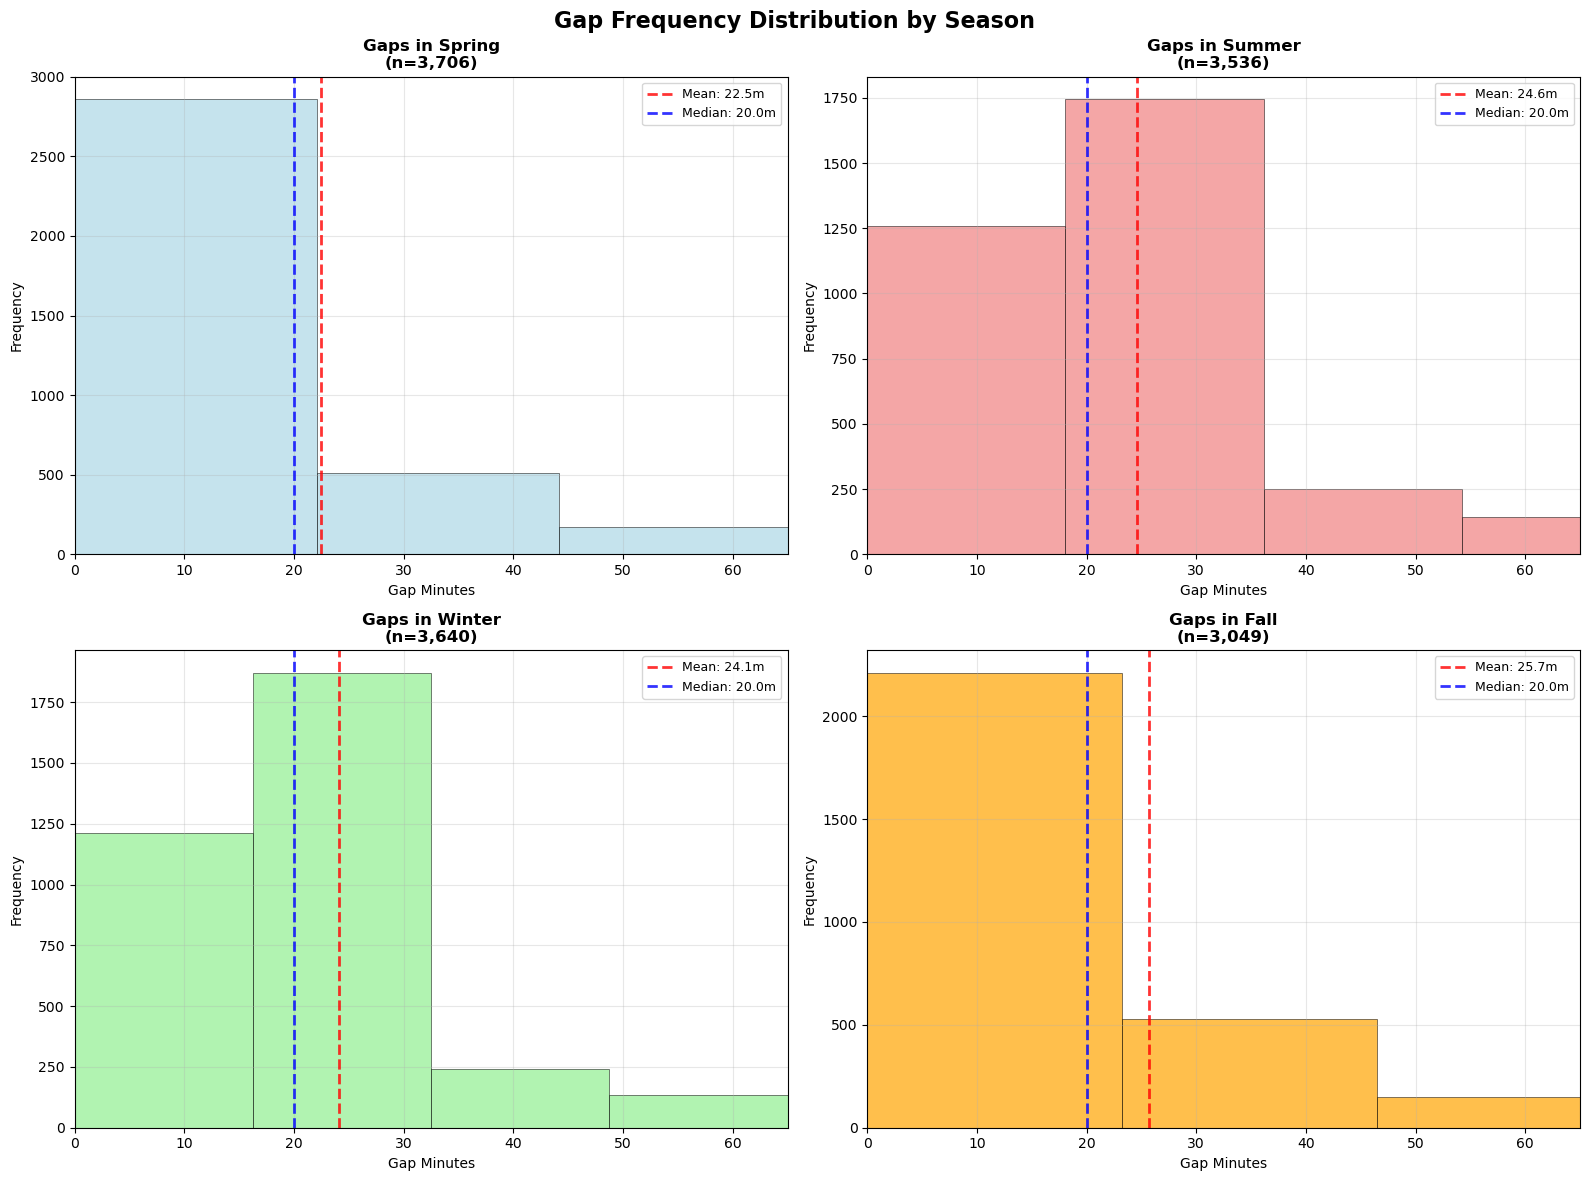

In [ ]:
# Compare gap distributions by season
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

seasons = cleaned_df['Season'].unique()
colors = ['lightblue', 'lightcoral', 'lightgreen', 'orange']

for i, season in enumerate(seasons):
    if i < 4:
        season_data = cleaned_df[cleaned_df['Season'] == season]['Min Gap']
        
        n, bins, patches = axes[i].hist(season_data, bins=40, alpha=0.7, color=colors[i], 
                                       edgecolor='black', linewidth=0.5)
        
        mean_gap = season_data.mean()
        median_gap = season_data.median()
        
        axes[i].axvline(mean_gap, color='red', linestyle='--', linewidth=2, alpha=0.8, 
                       label=f'Mean: {mean_gap:.1f}m')
        axes[i].axvline(median_gap, color='blue', linestyle='--', linewidth=2, alpha=0.8, 
                       label=f'Median: {median_gap:.1f}m')
        
        axes[i].set_title(f'Gaps in {season}\n(n={len(season_data):,})', fontweight='bold', fontsize=12)
        axes[i].set_xlabel('Gap Minutes', fontsize=10)
        axes[i].set_ylabel('Frequency', fontsize=10)
        axes[i].grid(alpha=0.3)
        axes[i].legend(fontsize=9)
        
        # Set consistent x-axis limits
        max_gap = cleaned_df['Min Gap'].quantile(0.95)
        axes[i].set_xlim(0, max_gap)

plt.suptitle('Gap Frequency Distribution by Season', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

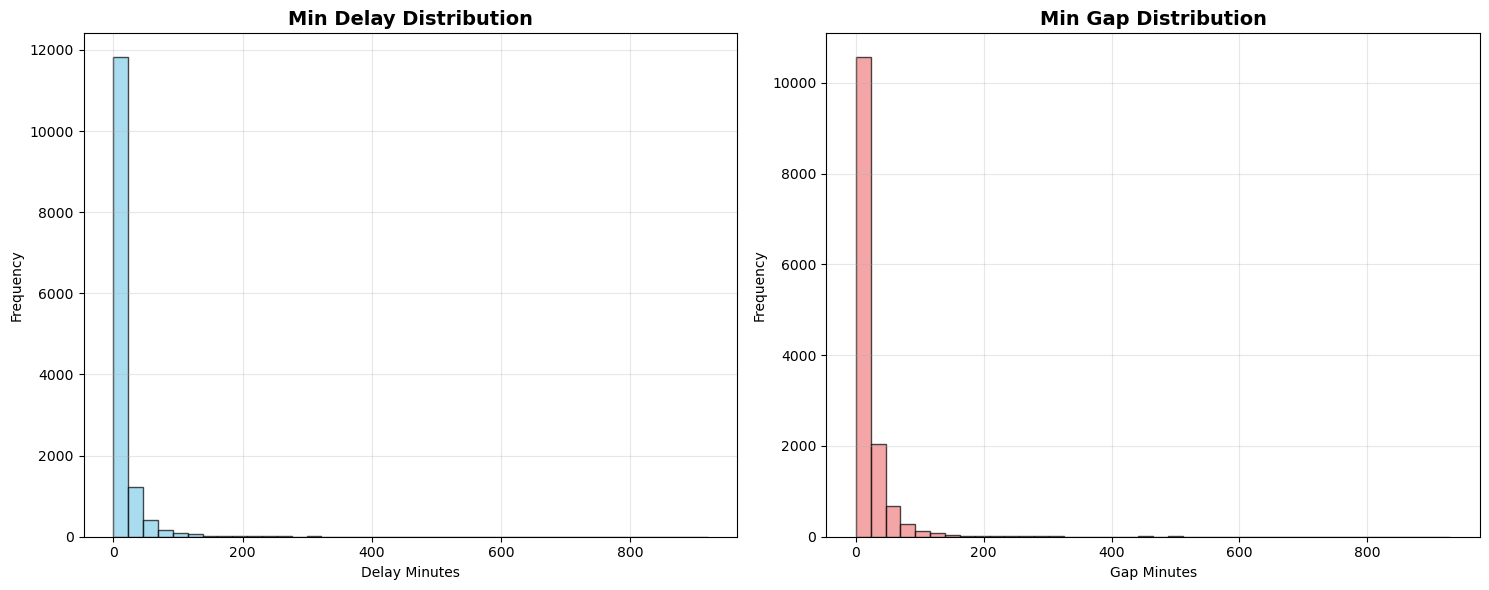

COMPARISON: MIN DELAY vs MIN GAP
Min Delay - Mean: 16.18, Median: 10.00
Min Gap   - Mean: 24.12, Median: 20.00
Correlation between Delay and Gap: 0.972


In [ ]:
# Compare Delay vs Gap distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Min Delay
ax1.hist(cleaned_df['Min Delay'], bins=40, color='skyblue', alpha=0.7, edgecolor='black', label='Min Delay')
ax1.set_title('Min Delay Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Delay Minutes')
ax1.set_ylabel('Frequency')
ax1.grid(alpha=0.3)

# Min Gap
ax2.hist(cleaned_df['Min Gap'], bins=40, color='lightcoral', alpha=0.7, edgecolor='black', label='Min Gap')
ax2.set_title('Min Gap Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Gap Minutes')
ax2.set_ylabel('Frequency')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print comparison statistics
print("COMPARISON: MIN DELAY vs MIN GAP")
print("="*50)
print(f"Min Delay - Mean: {cleaned_df['Min Delay'].mean():.2f}, Median: {cleaned_df['Min Delay'].median():.2f}")
print(f"Min Gap   - Mean: {cleaned_df['Min Gap'].mean():.2f}, Median: {cleaned_df['Min Gap'].median():.2f}")
print(f"Correlation between Delay and Gap: {cleaned_df['Min Delay'].corr(cleaned_df['Min Gap']):.3f}")

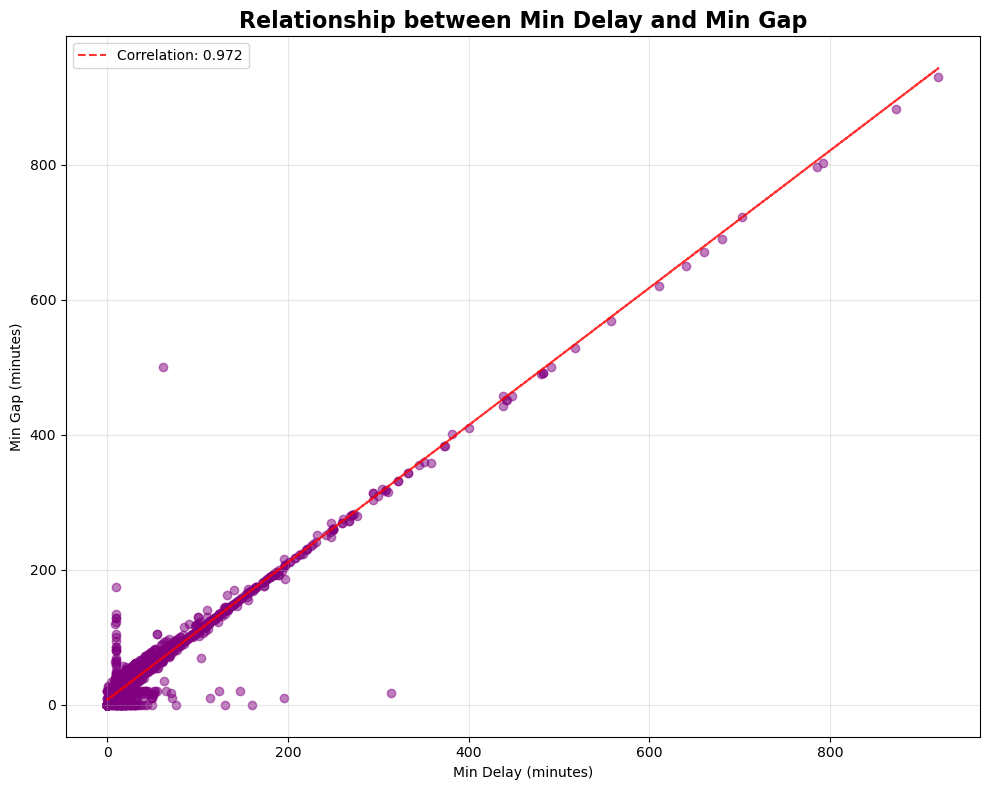

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(cleaned_df['Min Delay'], cleaned_df['Min Gap'], alpha=0.5, color='purple')
plt.title('Relationship between Min Delay and Min Gap', fontsize=16, fontweight='bold')
plt.xlabel('Min Delay (minutes)')
plt.ylabel('Min Gap (minutes)')
plt.grid(alpha=0.3)

# Add correlation line if there's a strong relationship
correlation = cleaned_df['Min Delay'].corr(cleaned_df['Min Gap'])
if abs(correlation) > 0.3:
    z = np.polyfit(cleaned_df['Min Delay'], cleaned_df['Min Gap'], 1)
    p = np.poly1d(z)
    plt.plot(cleaned_df['Min Delay'], p(cleaned_df['Min Delay']), "r--", alpha=0.8, 
             label=f'Correlation: {correlation:.3f}')
    plt.legend()

plt.tight_layout()
plt.show()

REGRESSION ANALYSIS LESS THAN 200 MINUTES

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# Filter data for Min Delay < 200 minutes
filtered_df = cleaned_df[cleaned_df['Min Delay'] < 200].copy()
print(f"Original dataset: {len(cleaned_df)} records")
print(f"Filtered dataset (Min Delay < 200): {len(filtered_df)} records")
print(f"Removed {len(cleaned_df) - len(filtered_df)} records with delays >= 200 minutes")

# Basic statistics of filtered data
print("\nFiltered Data Statistics:")
print(filtered_df['Min Delay'].describe())

Original dataset: 13931 records
Filtered dataset (Min Delay < 200): 13858 records
Removed 73 records with delays >= 200 minutes

Filtered Data Statistics:
count    13858.000000
mean        14.352720
std         20.153485
min          0.000000
25%          5.000000
50%         10.000000
75%         13.000000
max        197.000000
Name: Min Delay, dtype: float64


In [ ]:
# Select features for regression
# Numerical features
numerical_features = ['Min Gap', 'Hour of Day', 'Month', 'Week', 'Day of Month']

# Categorical features
categorical_features = ['Line', 'Day', 'Season', 'Bound', 'Incident']

# Target variable
target = 'Min Delay'

# Create feature set and target
X = filtered_df[numerical_features + categorical_features].copy()
y = filtered_df[target]

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Check for missing values
print("\nMissing values in features:")
print(X.isnull().sum())

Feature matrix shape: (13858, 10)
Target vector shape: (13858,)

Missing values in features:
Min Gap            0
Hour of Day        0
Month              0
Week               0
Day of Month       0
Line               0
Day                0
Season             0
Bound           1960
Incident           0
dtype: int64


In [ ]:
# Filter data for Min Delay < 200 minutes
filtered_df = cleaned_df[cleaned_df['Min Delay'] < 200].copy()
print(f"Original dataset: {len(cleaned_df)} records")
print(f"Filtered dataset (Min Delay < 200): {len(filtered_df)} records")
print(f"Removed {len(cleaned_df) - len(filtered_df)} records with delays >= 200 minutes")

# Check the missing values in Bound
print(f"\nMissing values in 'Bound': {filtered_df['Bound'].isnull().sum()}")
print("Unique values in Bound:")
print(filtered_df['Bound'].value_counts(dropna=False))

Original dataset: 13931 records
Filtered dataset (Min Delay < 200): 13858 records
Removed 73 records with delays >= 200 minutes

Missing values in 'Bound': 1960
Unique values in Bound:
Bound
E       4324
W       4303
NaN     1959
S       1655
N       1616
<NA>       1
Name: count, dtype: int64


In [ ]:
# Filter data for Min Delay < 200 minutes AND remove missing values
filtered_df = cleaned_df[
    (cleaned_df['Min Delay'] < 200) & 
    (cleaned_df['Bound'].notna())
].copy()

print(f"Original dataset: {len(cleaned_df)} records")
print(f"Filtered dataset (Min Delay < 200 & no missing Bound): {len(filtered_df)} records")
print(f"Removed {len(cleaned_df) - len(filtered_df)} records")

# Check for any remaining missing values
print("\nMissing values in filtered dataset:")
print(filtered_df.isnull().sum())

# Basic statistics of filtered data
print("\nFiltered Data Statistics:")
print(f"Min Delay - Mean: {filtered_df['Min Delay'].mean():.2f}, Std: {filtered_df['Min Delay'].std():.2f}")
print(f"Min Gap - Mean: {filtered_df['Min Gap'].mean():.2f}, Std: {filtered_df['Min Gap'].std():.2f}")

Original dataset: 13931 records
Filtered dataset (Min Delay < 200 & no missing Bound): 11898 records
Removed 2033 records

Missing values in filtered dataset:
Date              0
Line              0
Time              0
Day               0
Location          0
Incident          0
Min Delay         0
Min Gap           0
Bound             0
Vehicle         208
Month             0
Week              0
Day of Month      0
Hour of Day       0
Season            0
Bound_E           0
Bound_N           0
dtype: int64

Filtered Data Statistics:
Min Delay - Mean: 14.50, Std: 19.72
Min Gap - Mean: 22.62, Std: 22.29


In [ ]:
# Create a completely clean dataset - remove ANY missing values
clean_df = cleaned_df.dropna().copy()

print("DATASET CLEANING SUMMARY")
print("=" * 50)
print(f"Original dataset: {len(cleaned_df):,} records")
print(f"After removing ALL missing values: {len(clean_df):,} records")
print(f"Records removed: {len(cleaned_df) - len(clean_df):,}")
print(f"Percentage of data kept: {len(clean_df)/len(cleaned_df)*100:.1f}%")

# Check for any remaining missing values
print("\nMissing values in cleaned dataset:")
print(clean_df.isnull().sum())

# Filter for Min Delay < 200 minutes on the clean dataset
filtered_df = clean_df[clean_df['Min Delay'] < 200].copy()
print(f"\nAfter filtering Min Delay < 200: {len(filtered_df):,} records")

DATASET CLEANING SUMMARY
Original dataset: 13,931 records
After removing ALL missing values: 11,744 records
Records removed: 2,187
Percentage of data kept: 84.3%

Missing values in cleaned dataset:
Date            0
Line            0
Time            0
Day             0
Location        0
Incident        0
Min Delay       0
Min Gap         0
Bound           0
Vehicle         0
Month           0
Week            0
Day of Month    0
Hour of Day     0
Season          0
Bound_E         0
Bound_N         0
dtype: int64

After filtering Min Delay < 200: 11,690 records



CLEAN DATASET STATISTICS
Target Variable (Min Delay):
count    11690.000000
mean        14.533704
std         19.584754
min          0.000000
25%          6.000000
50%         10.000000
75%         13.000000
max        197.000000
Name: Min Delay, dtype: float64

Numerical Features:
            Min Gap   Hour of Day         Month          Week  Day of Month
count  11690.000000  11690.000000  11690.000000  11690.000000  11690.000000
mean      22.758426     12.659709      6.166638     25.260736     15.712147
std       22.116858      6.435465      3.404357     14.897073      8.871418
min        0.000000      0.000000      1.000000      1.000000      1.000000
25%       14.000000      8.000000      3.000000     13.000000      8.000000
50%       20.000000     13.000000      6.000000     25.000000     16.000000
75%       22.000000     18.000000      9.000000     38.000000     23.000000
max      501.000000     23.000000     12.000000     53.000000     31.000000

Categorical Features Summary:
L

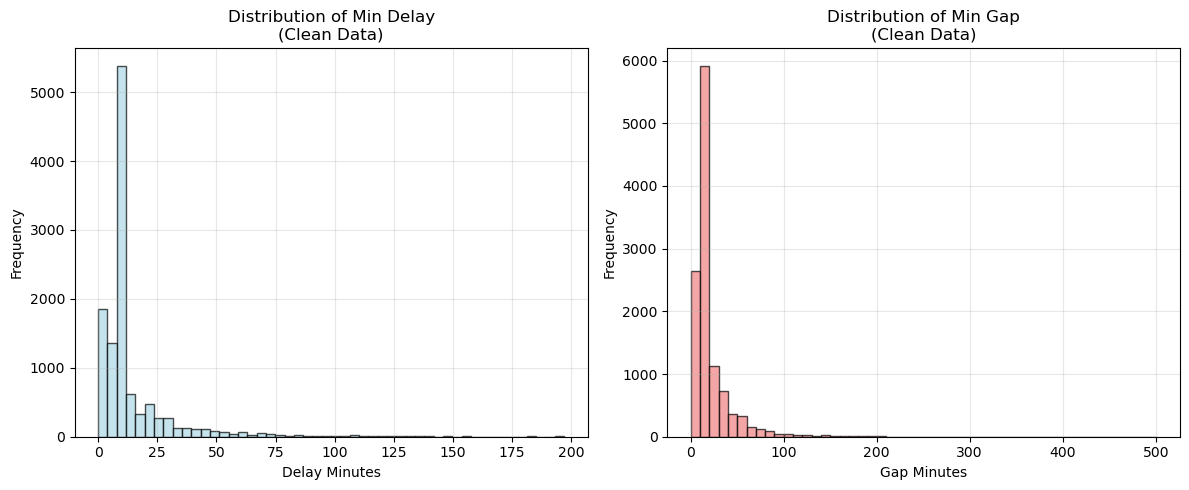

In [ ]:
# Basic statistics of the completely clean dataset
print("\nCLEAN DATASET STATISTICS")
print("=" * 40)
print("Target Variable (Min Delay):")
print(filtered_df['Min Delay'].describe())

print("\nNumerical Features:")
print(filtered_df[['Min Gap', 'Hour of Day', 'Month', 'Week', 'Day of Month']].describe())

print("\nCategorical Features Summary:")
for col in ['Line', 'Day', 'Season', 'Bound', 'Incident']:
    print(f"{col}: {filtered_df[col].nunique()} unique values")

# Visualize the target distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(filtered_df['Min Delay'], bins=50, color='lightblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Min Delay\n(Clean Data)')
plt.xlabel('Delay Minutes')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(filtered_df['Min Gap'], bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
plt.title('Distribution of Min Gap\n(Clean Data)')
plt.xlabel('Gap Minutes')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

#### Plots for operational guidance

Incident Types by Severity Pattern (counts):
Severity                  Minor  Moderate  Major  Total
Incident                                               
Cleaning - Unsanitary      1236       108     13   1357
Collision - TTC Involved    461        43    149    653
Diversion                   512       540    650   1702
Emergency Services          810       380    120   1310
General Delay              1368       307     63   1738
Held By                     386       216    136    738
Investigation               161        36     18    215
Mechanical                 1540        81     47   1668
Operations                 1757       370    100   2227
Overhead                     27         8     18     53
Rail/Switches                95        21     11    127
Security                   1396       296    117   1809
Utilized Off Route          299        26      2    327


<Figure size 1000x700 with 0 Axes>

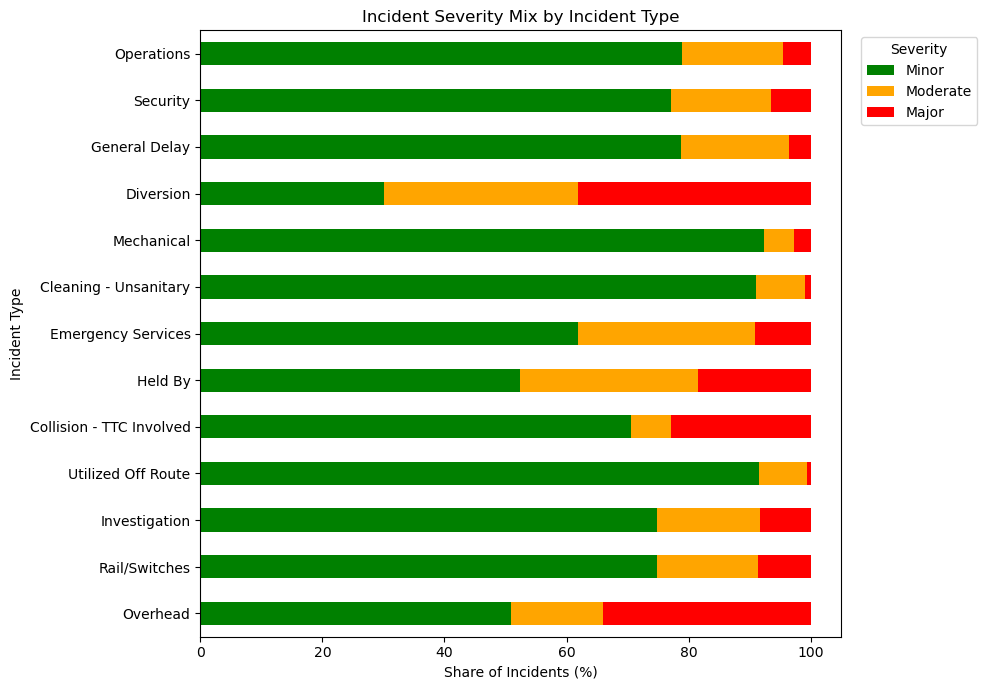

In [ ]:
# Create incident severity categories
def categorize_severity(delay):
    if delay <= 10: return 'Minor'
    elif delay <= 30: return 'Moderate' 
    else: return 'Major'

severity_df = cleaned_df.copy()
severity_df.loc[:, 'Severity'] = severity_df['Min Delay'].apply(categorize_severity)

# Analyze what drives severity
severity_patterns = (
    severity_df
    .groupby(["Incident", "Severity"])
    .agg(
        incident_count=("Min Delay", "size"),
        mean_delay=("Min Delay", "mean"),
        mean_hour=("Hour of Day", "mean"),
        most_common_line=("Line", lambda s: s.mode().iloc[0] if not s.mode().empty else np.nan)
    )
    .reset_index()
)

# Pivot for better visualization
severity_pivot = (
    severity_patterns
    .pivot_table(
        index="Incident",
        columns="Severity",
        values="incident_count",
        aggfunc="sum",
        fill_value=0
    )
    .reindex(columns=["Minor", "Moderate", "Major"], fill_value=0)  # fixed order
)

# Add totals and convert to percentages
severity_pivot["Total"] = severity_pivot.sum(axis=1)
severity_pct = (
    severity_pivot[["Minor", "Moderate", "Major"]]
    .div(severity_pivot["Total"], axis=0) * 100
)

# Sort incidents by total number of incidents (ascending)
severity_pct = severity_pct.loc[severity_pivot["Total"].sort_values().index]

print("Incident Types by Severity Pattern (counts):")
print(severity_pivot[["Minor", "Moderate", "Major", "Total"]])

# Visualize
plt.figure(figsize=(10, 7))
ax = severity_pct.plot(
    kind="barh",
    stacked=True,
    figsize=(10, 7),
    color=["green", "orange", "red"]
)

ax.set_title("Incident Severity Mix by Incident Type")
ax.set_xlabel("Share of Incidents (%)")
ax.set_ylabel("Incident Type")


ax.set_xlim(0, 105)
ax.legend(title="Severity", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

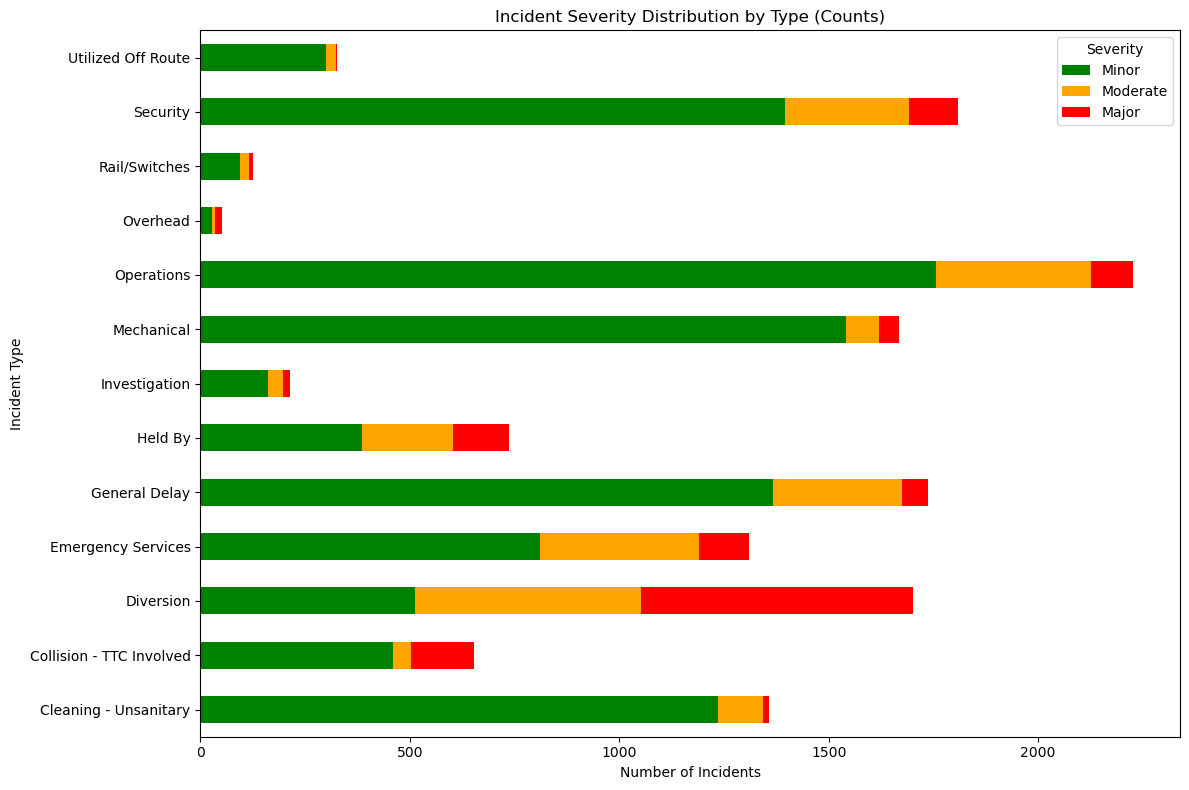

In [ ]:
# --- 4. Visualization: horizontal stacked bar chart (counts) -----------------
plt.figure(figsize=(12, 8))
ax = severity_pivot[["Minor", "Moderate", "Major"]].plot(
    kind="barh",
    stacked=True,
    figsize=(12, 8),
    color=["green", "orange", "red"]
)

plt.title("Incident Severity Distribution by Type (Counts)")
plt.xlabel("Number of Incidents")
plt.ylabel("Incident Type")


plt.legend(title="Severity")
plt.tight_layout()
plt.show()

## When and where do delays actually start?
TEMPORAL HOTSPOT ANALYSIS

Top 15 Temporal Hotspots:
                                  Avg_Delay  Incident_Count  Most_Common_Line
Time_Category Incident                                                       
Midday        Operations              10.89             575               504
Overnight     Security                10.08             540               504
Evening Rush  Operations              11.13             537               501
              General Delay            5.01             530               510
Midday        Mechanical               8.80             493               501
Morning Rush  Operations              11.77             463               504
              Security                 9.74             445               501
              Mechanical               9.73             430               501
Midday        General Delay            7.97             416               510
Overnight     Emergency Services      14.11             393               505
Evening Rush  Diversion               

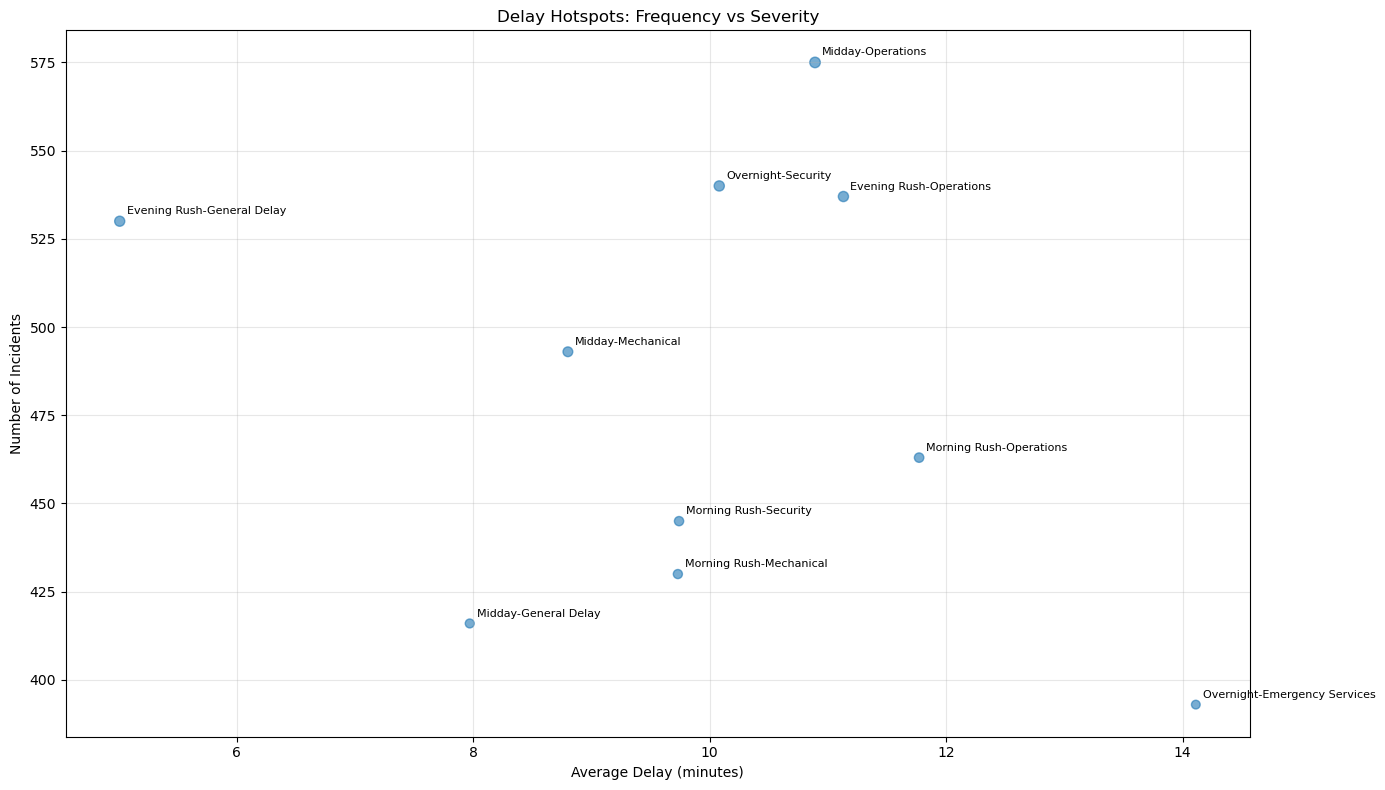

In [22]:
# Create time categories
def time_category(hour):
    if 5 <= hour < 10: return 'Morning Rush'
    elif 10 <= hour < 15: return 'Midday'
    elif 15 <= hour < 19: return 'Evening Rush'
    elif 19 <= hour < 23: return 'Evening'
    else: return 'Overnight'

hotspot_df = cleaned_df.copy()
hotspot_df.loc[:, 'Time_Category'] = hotspot_df['Hour of Day'].apply(time_category)

# Analyze hotspots
hotspot_analysis = hotspot_df.groupby(['Time_Category', 'Incident']).agg({
    'Min Delay': ['mean', 'count'],
    'Line': lambda x: x.mode()[0]
}).round(2)

hotspot_analysis.columns = ['Avg_Delay', 'Incident_Count', 'Most_Common_Line']
hotspot_analysis = hotspot_analysis.sort_values('Incident_Count', ascending=False)

print("Top 15 Temporal Hotspots:")
print(hotspot_analysis.head(15))

# Visualize
plt.figure(figsize=(14, 8))
top_hotspots = hotspot_analysis.head(10).reset_index()
plt.scatter(top_hotspots['Avg_Delay'], top_hotspots['Incident_Count'], 
           s=top_hotspots['Incident_Count']/10, alpha=0.6)
plt.xlabel('Average Delay (minutes)')
plt.ylabel('Number of Incidents')
plt.title('Delay Hotspots: Frequency vs Severity')

# Add labels
for i, row in top_hotspots.iterrows():
    plt.annotate(f"{row['Time_Category']}-{row['Incident']}", 
                (row['Avg_Delay'], row['Incident_Count']),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Which lines are most vulnerable to which incidents?
LINE VULNERABILITY ANALYSIS

In [25]:
vulnerability_matrix = cleaned_df.pivot_table(
    index='Line',
    columns='Incident', 
    values='Min Delay',
    aggfunc=['mean', 'count'],
    fill_value=0
)

# Flatten column names
vulnerability_matrix.columns = ['_'.join(col).strip() for col in vulnerability_matrix.columns.values]

# Find most vulnerable lines
line_vulnerability = cleaned_df.groupby('Line').agg({
    'Min Delay': 'mean',
    'Incident': 'nunique',
    'Min Gap': 'mean'
}).sort_values('Min Delay', ascending=False)

print("Most Vulnerable Lines (Highest Average Delays):")
print(line_vulnerability.head(10))

# Incident type frequency by line
incident_by_line = pd.crosstab(cleaned_df['Line'], cleaned_df['Incident'], normalize='index') * 100
print("\nIncident Type Distribution by Line (%):")
print(incident_by_line.round(1))

Most Vulnerable Lines (Highest Average Delays):
      Min Delay  Incident    Min Gap
Line                                
303   48.333333         6  65.416667
508   42.323529        12  56.137255
310   31.772727         6  49.318182
301   25.289474        13  40.000000
305   22.142857         5  38.928571
507   20.616408        12  29.447894
503   20.413613        13  29.225131
306   19.471264        10  31.367816
312   19.250000         3  43.500000
511   18.694946        13  26.241877

Incident Type Distribution by Line (%):
Incident  Cleaning - Unsanitary  Collision - TTC Involved  Diversion  \
Line                                                                   
301                         6.6                       0.7       11.2   
303                         0.0                       0.0       25.0   
304                         7.3                       4.9       17.1   
305                        28.6                       0.0       14.3   
306                         9.2    

In [26]:
# LINE VULNERABILITY ANALYSIS - VISUALIZATION
print("LINE VULNERABILITY ANALYSIS")
print("=" * 50)

# Calculate vulnerability metrics
line_vulnerability = cleaned_df.groupby('Line').agg({
    'Min Delay': ['mean', 'std', 'count'],
    'Incident': 'nunique',
    'Min Gap': 'mean',
    'Hour of Day': 'mean'
}).round(2)

# Flatten column names
line_vulnerability.columns = ['Avg_Delay', 'Delay_Std', 'Incident_Count', 'Unique_Incident_Types', 'Avg_Gap', 'Avg_Hour']

# Sort by average delay (most vulnerable first)
line_vulnerability = line_vulnerability.sort_values('Avg_Delay', ascending=False)

print("Line Vulnerability Metrics (Sorted by Average Delay):")
print(line_vulnerability.head(15))

LINE VULNERABILITY ANALYSIS
Line Vulnerability Metrics (Sorted by Average Delay):
      Avg_Delay  Delay_Std  Incident_Count  Unique_Incident_Types  Avg_Gap  \
Line                                                                         
303       48.33      80.05              12                      6    65.42   
508       42.32     109.31             102                     12    56.14   
310       31.77      65.94              22                      6    49.32   
301       25.29      47.48             152                     13    40.00   
305       22.14      25.37              14                      5    38.93   
507       20.62      38.63             451                     12    29.45   
503       20.41      41.47             955                     13    29.23   
306       19.47      25.69              87                     10    31.37   
312       19.25      12.84               4                      3    43.50   
511       18.69      49.95             554                  

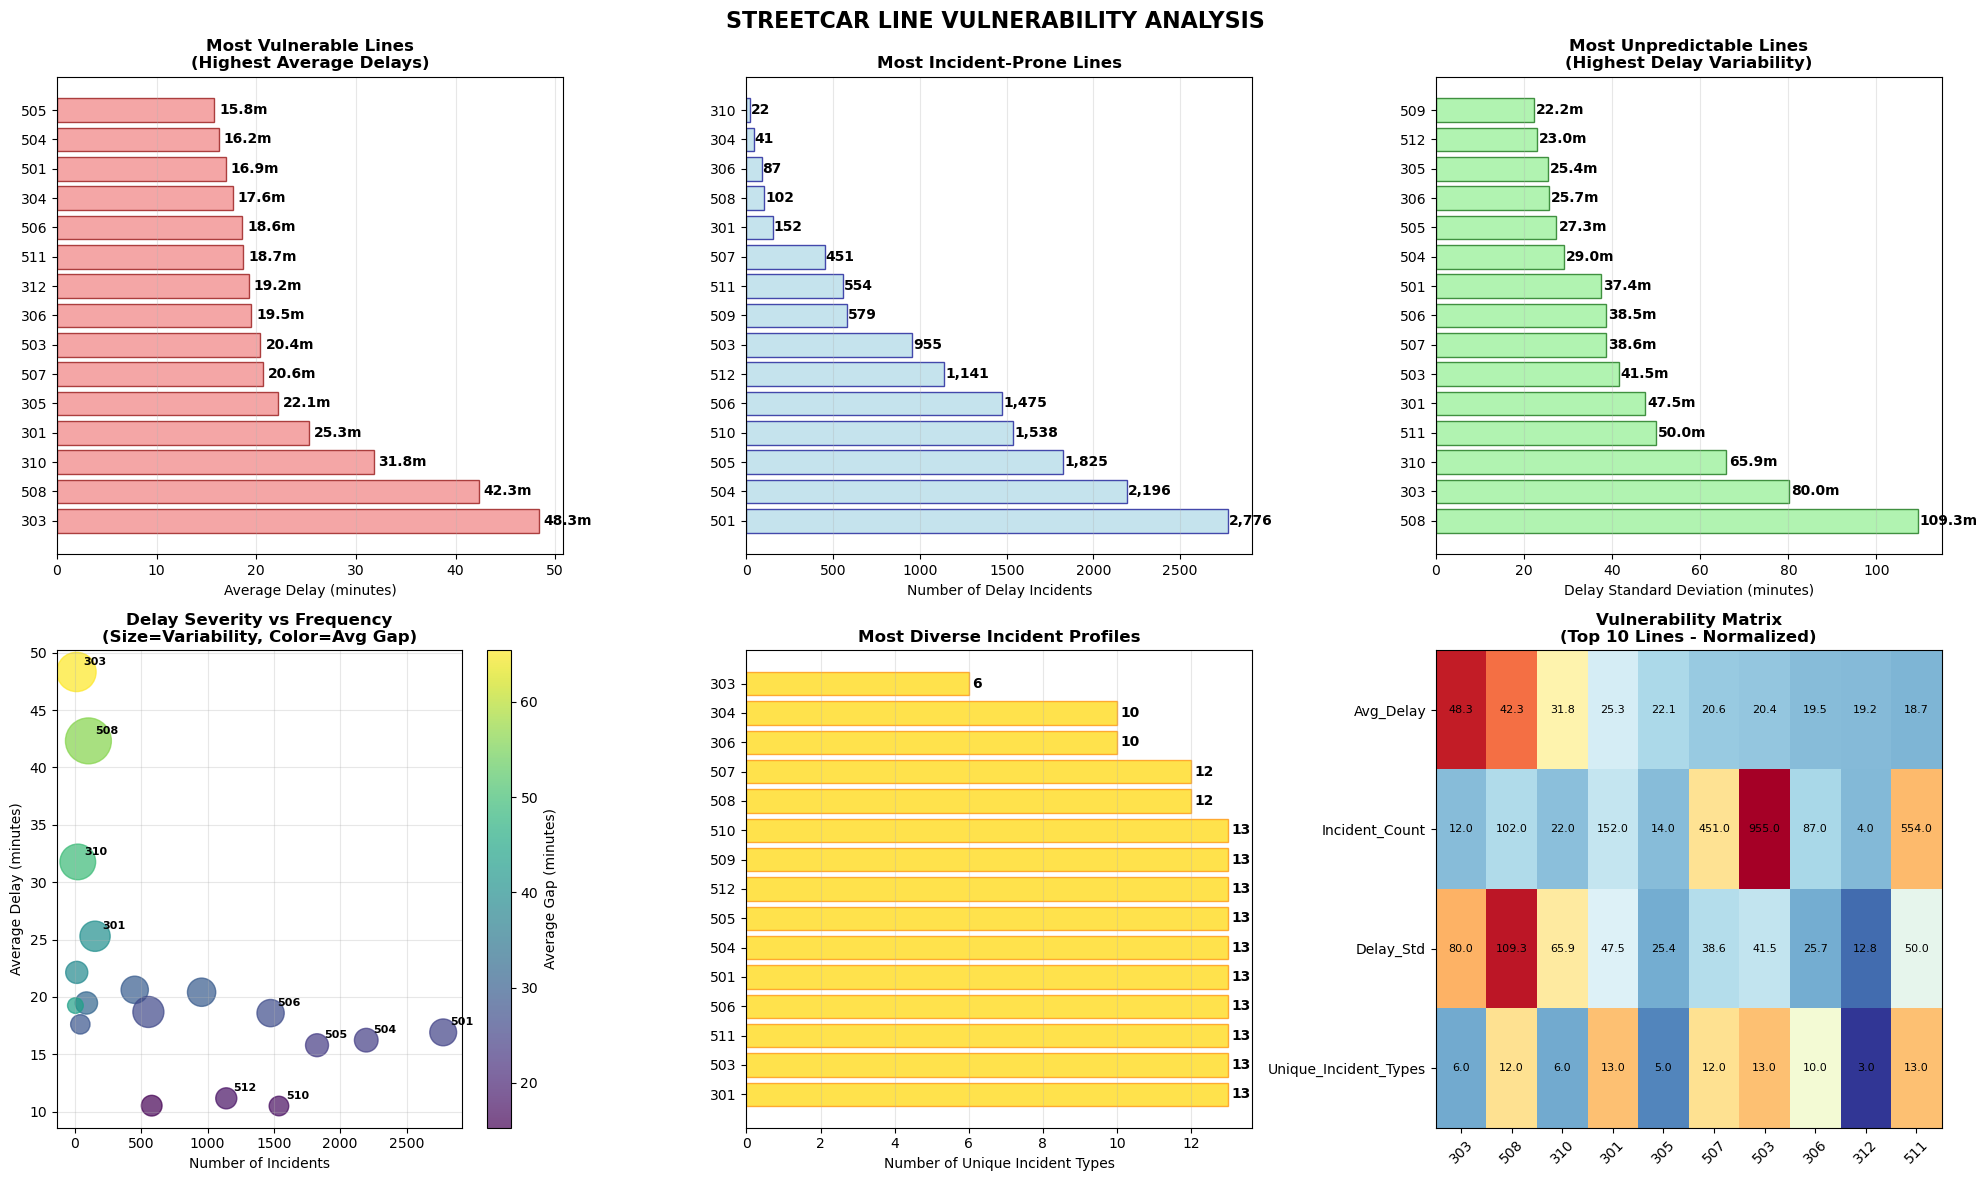

In [27]:
# Create comprehensive vulnerability dashboard
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('STREETCAR LINE VULNERABILITY ANALYSIS', fontsize=16, fontweight='bold')

# 1. Average Delay by Line (Top 15)
top_15_delay = line_vulnerability.head(15)
bars1 = axes[0,0].barh(range(len(top_15_delay)), top_15_delay['Avg_Delay'], 
                      color='lightcoral', alpha=0.7, edgecolor='darkred')
axes[0,0].set_yticks(range(len(top_15_delay)))
axes[0,0].set_yticklabels(top_15_delay.index)
axes[0,0].set_xlabel('Average Delay (minutes)')
axes[0,0].set_title('Most Vulnerable Lines\n(Highest Average Delays)', fontweight='bold')
axes[0,0].grid(axis='x', alpha=0.3)

# Add value labels
for i, bar in enumerate(bars1):
    width = bar.get_width()
    axes[0,0].text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                  f'{width:.1f}m', ha='left', va='center', fontweight='bold')

# 2. Number of Incidents by Line (Top 15)
top_15_incidents = line_vulnerability.nlargest(15, 'Incident_Count')
bars2 = axes[0,1].barh(range(len(top_15_incidents)), top_15_incidents['Incident_Count'], 
                      color='lightblue', alpha=0.7, edgecolor='darkblue')
axes[0,1].set_yticks(range(len(top_15_incidents)))
axes[0,1].set_yticklabels(top_15_incidents.index)
axes[0,1].set_xlabel('Number of Delay Incidents')
axes[0,1].set_title('Most Incident-Prone Lines', fontweight='bold')
axes[0,1].grid(axis='x', alpha=0.3)

# Add value labels
for i, bar in enumerate(bars2):
    width = bar.get_width()
    axes[0,1].text(width + 5, bar.get_y() + bar.get_height()/2, 
                  f'{int(width):,}', ha='left', va='center', fontweight='bold')

# 3. Delay Consistency (Standard Deviation) - Top 15
top_15_std = line_vulnerability.nlargest(15, 'Delay_Std')
bars3 = axes[0,2].barh(range(len(top_15_std)), top_15_std['Delay_Std'], 
                      color='lightgreen', alpha=0.7, edgecolor='darkgreen')
axes[0,2].set_yticks(range(len(top_15_std)))
axes[0,2].set_yticklabels(top_15_std.index)
axes[0,2].set_xlabel('Delay Standard Deviation (minutes)')
axes[0,2].set_title('Most Unpredictable Lines\n(Highest Delay Variability)', fontweight='bold')
axes[0,2].grid(axis='x', alpha=0.3)

# Add value labels
for i, bar in enumerate(bars3):
    width = bar.get_width()
    axes[0,2].text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                  f'{width:.1f}m', ha='left', va='center', fontweight='bold')

# 4. Scatter: Average Delay vs Number of Incidents
scatter = axes[1,0].scatter(line_vulnerability['Incident_Count'], 
                           line_vulnerability['Avg_Delay'],
                           s=line_vulnerability['Delay_Std']*10,  # Size by variability
                           c=line_vulnerability['Avg_Gap'],       # Color by gap
                           cmap='viridis', alpha=0.7)
axes[1,0].set_xlabel('Number of Incidents')
axes[1,0].set_ylabel('Average Delay (minutes)')
axes[1,0].set_title('Delay Severity vs Frequency\n(Size=Variability, Color=Avg Gap)', fontweight='bold')
axes[1,0].grid(alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=axes[1,0])
cbar.set_label('Average Gap (minutes)')

# Label outliers
for line in line_vulnerability.index:
    if (line_vulnerability.loc[line, 'Incident_Count'] > 1000 or 
        line_vulnerability.loc[line, 'Avg_Delay'] > 25):
        axes[1,0].annotate(line, 
                          (line_vulnerability.loc[line, 'Incident_Count'], 
                           line_vulnerability.loc[line, 'Avg_Delay']),
                          xytext=(5, 5), textcoords='offset points', 
                          fontsize=8, fontweight='bold')

# 5. Unique Incident Types by Line (Top 15)
top_15_diverse = line_vulnerability.nlargest(15, 'Unique_Incident_Types')
bars5 = axes[1,1].barh(range(len(top_15_diverse)), top_15_diverse['Unique_Incident_Types'], 
                      color='gold', alpha=0.7, edgecolor='darkorange')
axes[1,1].set_yticks(range(len(top_15_diverse)))
axes[1,1].set_yticklabels(top_15_diverse.index)
axes[1,1].set_xlabel('Number of Unique Incident Types')
axes[1,1].set_title('Most Diverse Incident Profiles', fontweight='bold')
axes[1,1].grid(axis='x', alpha=0.3)

# Add value labels
for i, bar in enumerate(bars5):
    width = bar.get_width()
    axes[1,1].text(width + 0.1, bar.get_y() + bar.get_height()/2, 
                  f'{int(width)}', ha='left', va='center', fontweight='bold')

# 6. Vulnerability Matrix (Heatmap of key metrics)
vulnerability_metrics = line_vulnerability[['Avg_Delay', 'Incident_Count', 'Delay_Std', 'Unique_Incident_Types']]
vulnerability_metrics = vulnerability_metrics.head(10)  # Top 10 most vulnerable

# Normalize for heatmap
normalized_metrics = (vulnerability_metrics - vulnerability_metrics.mean()) / vulnerability_metrics.std()

im = axes[1,2].imshow(normalized_metrics.T, cmap='RdYlBu_r', aspect='auto')
axes[1,2].set_xticks(range(len(vulnerability_metrics)))
axes[1,2].set_xticklabels(vulnerability_metrics.index, rotation=45)
axes[1,2].set_yticks(range(len(vulnerability_metrics.columns)))
axes[1,2].set_yticklabels(vulnerability_metrics.columns)
axes[1,2].set_title('Vulnerability Matrix\n(Top 10 Lines - Normalized)', fontweight='bold')

# Add value annotations
for i in range(len(vulnerability_metrics)):
    for j in range(len(vulnerability_metrics.columns)):
        text = axes[1,2].text(i, j, f'{vulnerability_metrics.iloc[i, j]:.1f}',
                             ha="center", va="center", color="black", fontsize=8)

plt.tight_layout()
plt.show()


INCIDENT TYPE DISTRIBUTION BY LINE


<Figure size 1600x1000 with 0 Axes>

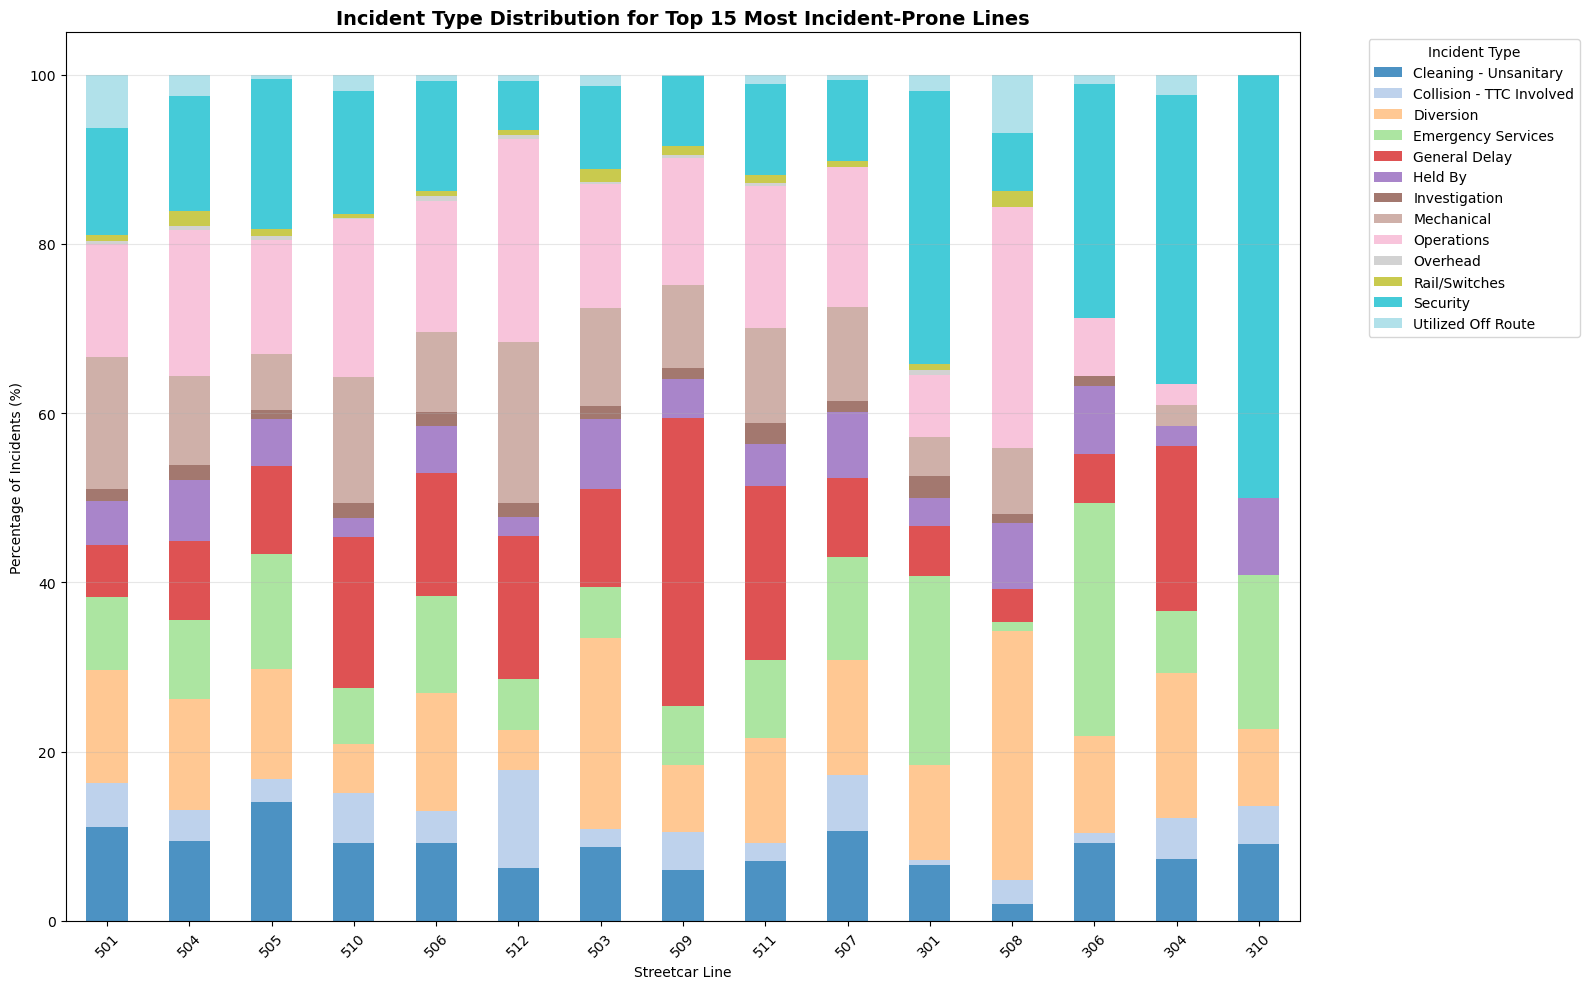


Top Incident Types for Most Vulnerable Lines:

Line 501:
  - Mechanical: 15.6%
  - Operations: 13.3%
  - Diversion: 13.3%

Line 504:
  - Operations: 17.3%
  - Security: 13.6%
  - Diversion: 13.1%

Line 505:
  - Security: 17.7%
  - Cleaning - Unsanitary: 14.1%
  - Emergency Services: 13.6%

Line 510:
  - Operations: 18.7%
  - General Delay: 17.9%
  - Mechanical: 14.8%

Line 506:
  - Operations: 15.5%
  - General Delay: 14.4%
  - Diversion: 13.9%


In [29]:
# Analyze what types of incidents affect each line
print("\nINCIDENT TYPE DISTRIBUTION BY LINE")
print("=" * 50)

# Get top 15 lines by incident count
top_lines = line_vulnerability.nlargest(15, 'Incident_Count').index

# Create incident distribution analysis
incident_by_line = pd.crosstab(cleaned_df['Line'], cleaned_df['Incident'], normalize='index') * 100
incident_by_line_top = incident_by_line.loc[top_lines]

# Plot stacked bar chart
plt.figure(figsize=(16, 10))
incident_by_line_top.plot(kind='bar', stacked=True, 
                         colormap='tab20', 
                         figsize=(16, 10),
                         alpha=0.8)
plt.title('Incident Type Distribution for Top 15 Most Incident-Prone Lines', 
          fontsize=14, fontweight='bold')
plt.xlabel('Streetcar Line')
plt.ylabel('Percentage of Incidents (%)')
plt.legend(title='Incident Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Show numerical breakdown
print("\nTop Incident Types for Most Vulnerable Lines:")
for line in top_lines[:5]:  # Show top 5
    line_incidents = incident_by_line.loc[line].nlargest(3)
    print(f"\nLine {line}:")
    for incident, percentage in line_incidents.items():
        if percentage > 5:  # Only show significant contributors
            print(f"  - {incident}: {percentage:.1f}%")


TEMPORAL VULNERABILITY PATTERNS


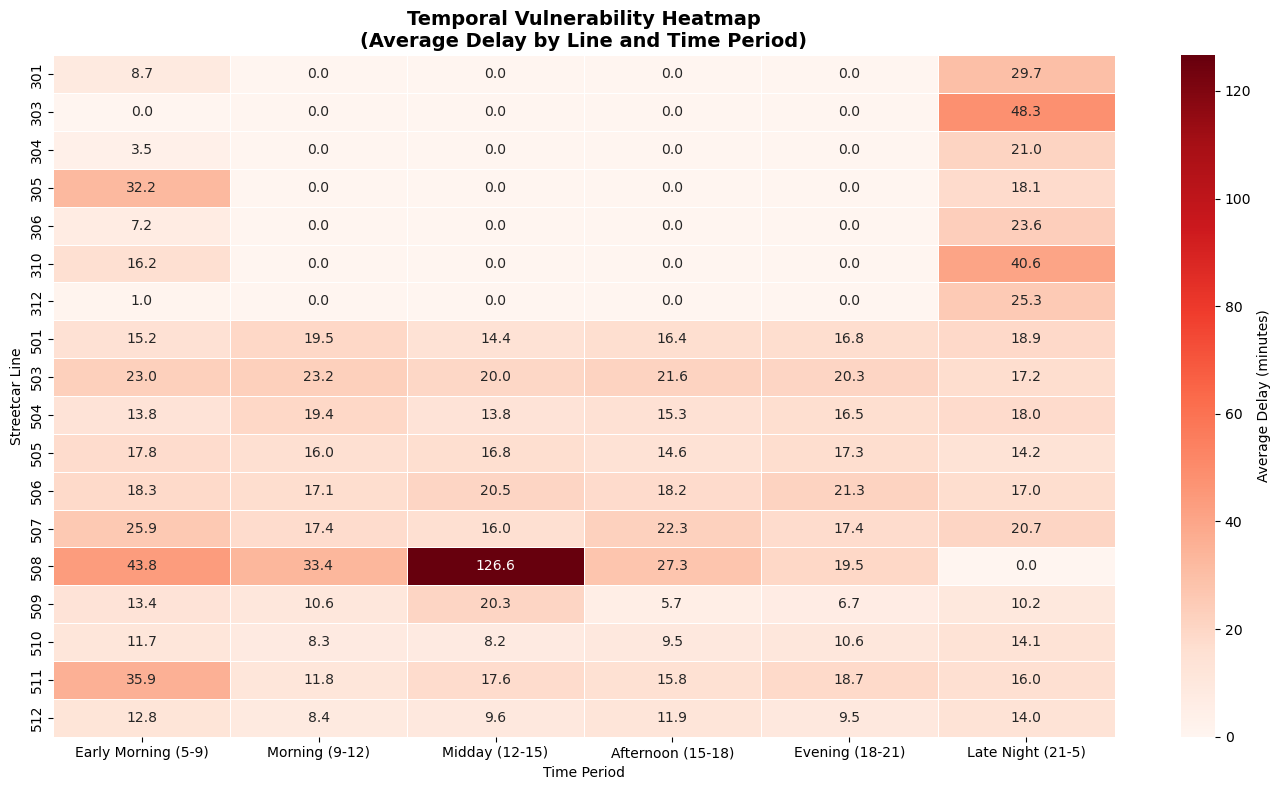

In [31]:
# Analyze when different lines are most vulnerable
print("\nTEMPORAL VULNERABILITY PATTERNS")
print("=" * 45)

# Create time categories for analysis
def time_period(hour):
    if 5 <= hour < 9: return 'Early Morning (5-9)'
    elif 9 <= hour < 12: return 'Morning (9-12)'
    elif 12 <= hour < 15: return 'Midday (12-15)'
    elif 15 <= hour < 18: return 'Afternoon (15-18)'
    elif 18 <= hour < 21: return 'Evening (18-21)'
    else: return 'Late Night (21-5)'

temporal_df = cleaned_df.copy()
temporal_df.loc[:, 'Time_Period'] = temporal_df['Hour of Day'].apply(time_period)

# Analyze top 10 most vulnerable lines
top_10_vulnerable = line_vulnerability.head(20).index
temporal_vulnerability = temporal_df[temporal_df['Line'].isin(top_10_vulnerable)]

# Create heatmap of delays by line and time period
heatmap_data = temporal_vulnerability.pivot_table(
    values='Min Delay',
    index='Line',
    columns='Time_Period',
    aggfunc='mean',
    fill_value=0
)

# Reorder time periods logically
time_order = ['Early Morning (5-9)', 'Morning (9-12)', 'Midday (12-15)', 
              'Afternoon (15-18)', 'Evening (18-21)', 'Late Night (21-5)']
heatmap_data = heatmap_data[time_order]

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='Reds', 
            linewidths=0.5, cbar_kws={'label': 'Average Delay (minutes)'})
plt.title('Temporal Vulnerability Heatmap\n(Average Delay by Line and Time Period)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Time Period')
plt.ylabel('Streetcar Line')
plt.tight_layout()
plt.show()

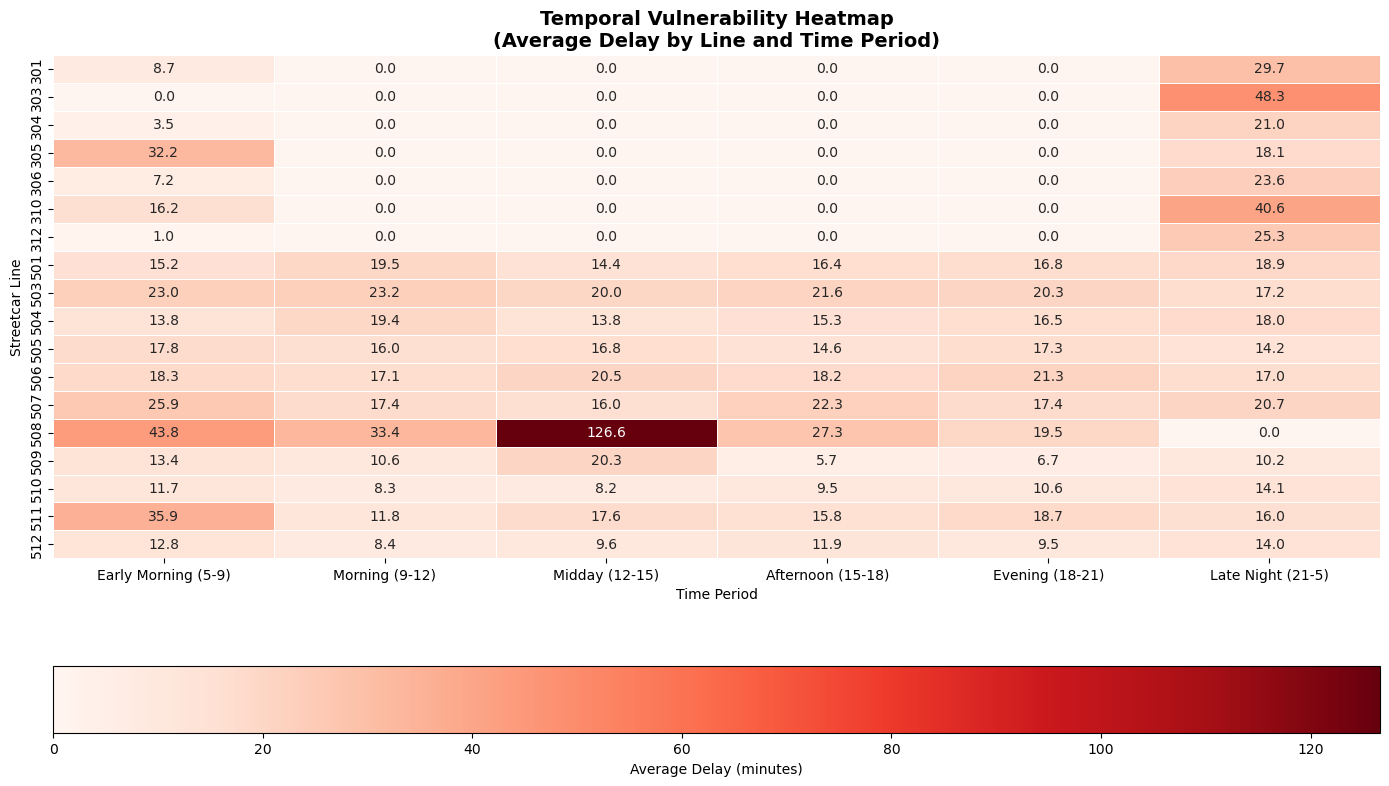

In [ ]:
plt.figure(figsize=(14, 8))

# Create heatmap without default colorbar
ax = sns.heatmap(
    heatmap_data, annot=True, fmt='.1f', cmap='Reds',
    linewidths=0.5, cbar=False
)

# Add colorbar manually at the bottom
# as horizontal colorbar
cbar = plt.colorbar(
    ax.get_children()[0],  
    orientation='horizontal',
    pad=0.15,               
)
cbar.set_label('Average Delay (minutes)')

plt.title(
    'Temporal Vulnerability Heatmap\n(Average Delay by Line and Time Period)',
    fontsize=14, fontweight='bold'
)
plt.xlabel('Time Period')
plt.ylabel('Streetcar Line')
plt.tight_layout()
plt.show()


LINE VULNERABILITY RISK MATRIX


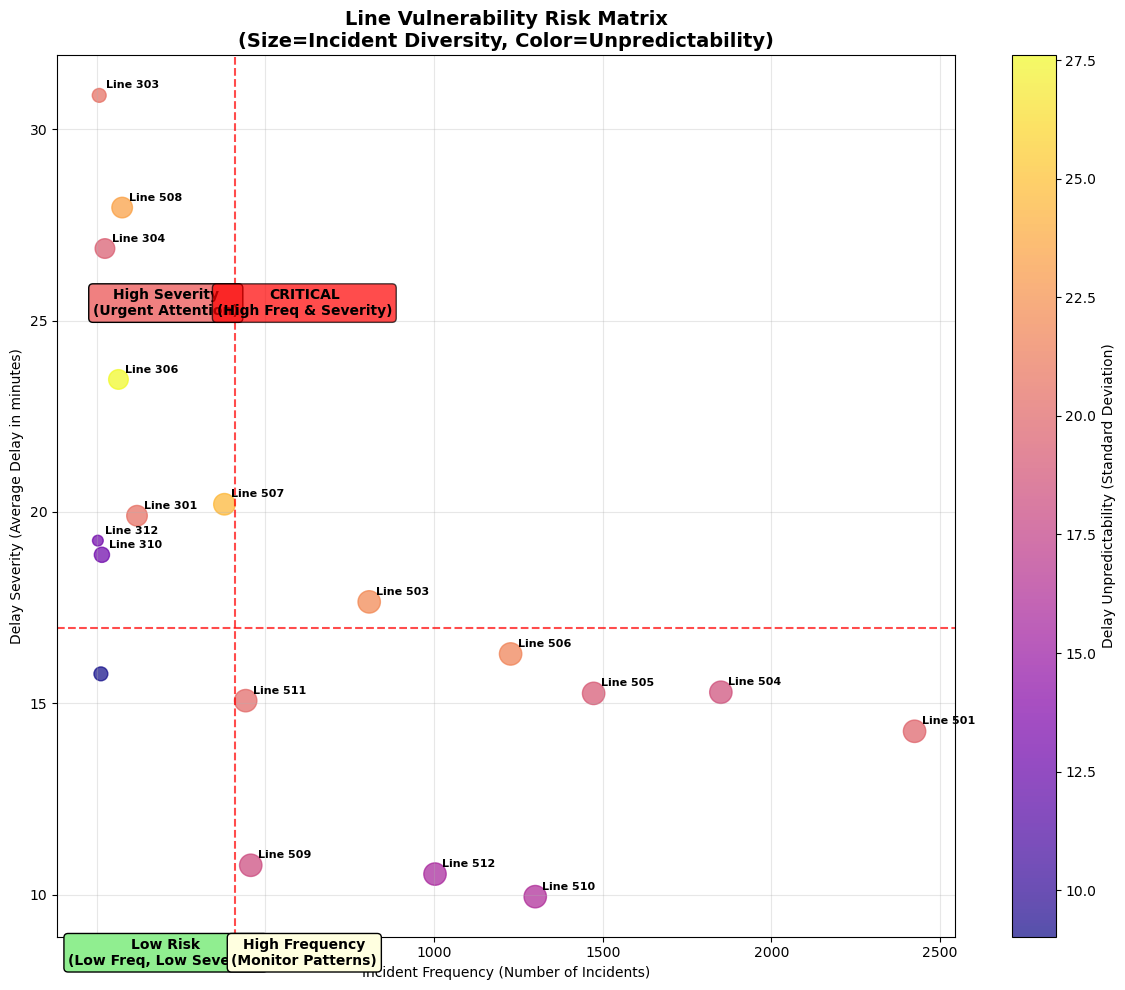


🚨 CRITICAL LINES (High Frequency & High Severity):
  Line 503: 17.6min avg delay, 808 incidents


In [76]:
# Create risk matrix: Frequency vs Severity
print("\nLINE VULNERABILITY RISK MATRIX")
print("=" * 45)

plt.figure(figsize=(12, 10))

# Create risk matrix
scatter = plt.scatter(line_vulnerability['Incident_Count'], 
                     line_vulnerability['Avg_Delay'],
                     s=line_vulnerability['Unique_Incident_Types']*20,  # Size by diversity
                     c=line_vulnerability['Delay_Std'],  # Color by unpredictability
                     cmap='plasma', alpha=0.7)

plt.xlabel('Incident Frequency (Number of Incidents)')
plt.ylabel('Delay Severity (Average Delay in minutes)')
plt.title('Line Vulnerability Risk Matrix\n(Size=Incident Diversity, Color=Unpredictability)', 
          fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)

# Add quadrants for risk assessment
median_freq = line_vulnerability['Incident_Count'].median()
median_severity = line_vulnerability['Avg_Delay'].median()

plt.axhline(y=median_severity, color='red', linestyle='--', alpha=0.7)
plt.axvline(x=median_freq, color='red', linestyle='--', alpha=0.7)

# Add quadrant labels
plt.text(median_freq/2, median_severity/2, 'Low Risk\n(Low Freq, Low Severity)', 
         ha='center', va='center', fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))
plt.text(median_freq*1.5, median_severity/2, 'High Frequency\n(Monitor Patterns)', 
         ha='center', va='center', fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow"))
plt.text(median_freq/2, median_severity*1.5, 'High Severity\n(Urgent Attention)', 
         ha='center', va='center', fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral"))
plt.text(median_freq*1.5, median_severity*1.5, 'CRITICAL\n(High Freq & Severity)', 
         ha='center', va='center', fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", facecolor="red", alpha=0.7))

# Label important lines
for line in line_vulnerability.index:
    if (line_vulnerability.loc[line, 'Incident_Count'] > median_freq or 
        line_vulnerability.loc[line, 'Avg_Delay'] > median_severity):
        plt.annotate(f'Line {line}', 
                    (line_vulnerability.loc[line, 'Incident_Count'], 
                     line_vulnerability.loc[line, 'Avg_Delay']),
                    xytext=(5, 5), textcoords='offset points', 
                    fontsize=8, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Delay Unpredictability (Standard Deviation)')

plt.tight_layout()
plt.show()

# Print critical lines
critical_lines = line_vulnerability[
    (line_vulnerability['Incident_Count'] > median_freq) & 
    (line_vulnerability['Avg_Delay'] > median_severity)
].sort_values('Avg_Delay', ascending=False)

print("\n🚨 CRITICAL LINES (High Frequency & High Severity):")
for line in critical_lines.index:
    avg_delay = critical_lines.loc[line, 'Avg_Delay']
    incidents = critical_lines.loc[line, 'Incident_Count']
    print(f"  Line {line}: {avg_delay:.1f}min avg delay, {incidents:,} incidents")